# 🧠 Deep Learning para Series Temporales Financieras
## Predicción del Índice VIX usando LSTM en PyTorch

---

**Autor**: Notebook Didáctico - Homework M4L10  
**Dataset**: `econotrend_vix_sim.csv` (Datos simulados del índice VIX)  
**Objetivo**: Construir un modelo LSTM para predecir la volatilidad del mercado

---

## 📚 Tabla de Contenidos

1. [Introducción y Contexto](#intro)
2. [Análisis Exploratorio de Datos (EDA)](#eda)
3. [Fundamentos Teóricos: LSTM](#teoria)
4. [Preparación de Datos](#preparacion)
5. [Construcción del Modelo LSTM](#modelo)
6. [Entrenamiento del Modelo](#entrenamiento)
7. [Evaluación y Métricas](#evaluacion)
8. [Arquitecturas Alternativas (GRU, BiLSTM)](#alternativas)
9. [Predicción Multi-Step](#multistep)
10. [Gestión del Modelo (Guardar/Cargar)](#gestion)
11. [Reflexiones y Conclusiones](#conclusiones)

<a id='intro'></a>
## 1. 🎯 Introducción y Contexto

### ¿Qué es el índice VIX?

El **VIX (Volatility Index)**, también conocido como el **"índice del miedo"**, es un indicador que mide la volatilidad esperada del mercado bursátil estadounidense (S&P 500) en los próximos 30 días. Fue creado por el Chicago Board Options Exchange (CBOE) en 1993.

#### 📊 WIKI: Conceptos Clave

**VIX (Volatility Index)**:
- Mide la volatilidad implícita de las opciones del S&P 500
- Valores típicos: 10-20 (mercado tranquilo), >30 (alta volatilidad/pánico)
- Se calcula en tiempo real durante el horario de mercado
- Un VIX alto indica incertidumbre y miedo en los mercados

**Serie Temporal Financiera**:
- Datos ordenados cronológicamente
- Características: tendencia, estacionalidad, volatilidad, autocorrelación
- Presentan "memoria": los valores pasados influyen en los futuros

**Random Walk Hypothesis**:
- Teoría que sugiere que los precios de activos siguen un camino aleatorio
- Si es cierto, predecir es muy difícil (eficiencia del mercado)
- Debatido constantemente en finanzas cuantitativas

---

### 🤔 ¿Por qué Deep Learning para Series Temporales?

**Modelos Tradicionales vs Deep Learning:**

| Aspecto | Modelos Clásicos (ARIMA, SARIMA) | Deep Learning (LSTM, GRU) |
|---------|----------------------------------|---------------------------|
| **Supuestos** | Requieren estacionariedad | Más flexibles, menos supuestos |
| **Relaciones** | Principalmente lineales | Capturan relaciones no lineales |
| **Features** | Se deben diseñar manualmente | Aprenden representaciones automáticamente |
| **Datos** | Funcionan bien con pocos datos | Necesitan más datos para entrenar |
| **Interpretabilidad** | Alta (parámetros claros) | Baja ("caja negra") |
| **Memoria a largo plazo** | Limitada (dependencia AR/MA) | Excelente (arquitectura recurrente) |

**Ventajas de LSTM para predicción del VIX:**
- Captura dependencias a largo plazo en la volatilidad
- No requiere estacionariedad estricta
- Puede aprender patrones complejos de pánico/calma
- Maneja bien secuencias irregulares

---

### 🎯 Objetivo de este Notebook

Construiremos un pipeline completo de Deep Learning para predicción de series temporales financieras:

1. ✅ Explorar y entender los datos del VIX
2. ✅ Preparar datos en formato de secuencias (ventanas deslizantes)
3. ✅ Implementar una arquitectura LSTM en PyTorch
4. ✅ Entrenar el modelo con técnicas de regularización
5. ✅ Evaluar con métricas robustas y comparar con baseline
6. ✅ Explorar arquitecturas alternativas (GRU, BiLSTM)
7. ✅ Realizar predicciones multi-paso
8. ✅ Reflexionar sobre la predictibilidad del VIX

## 📦 Importación de Librerías

Comenzamos importando todas las herramientas necesarias:

In [1]:
# ===========================
# LIBRERÍAS FUNDAMENTALES
# ===========================

# Manipulación de datos
import numpy as np              # Operaciones numéricas eficientes
import pandas as pd             # Manejo de DataFrames y series temporales

# Visualización
import matplotlib.pyplot as plt # Gráficos estáticos
import seaborn as sns           # Gráficos estadísticos elegantes

# PyTorch - Framework de Deep Learning
import torch                    # Tensores y operaciones de PyTorch
from torch import nn            # Módulo de redes neuronales
from torch.utils.data import Dataset, DataLoader  # Carga de datos eficiente

# Scikit-learn - Métricas y preprocesamiento
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Análisis de series temporales (para EDA)
from statsmodels.tsa.stattools import adfuller  # Test de estacionariedad
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # Autocorrelación

# Utilidades
import warnings
warnings.filterwarnings('ignore')  # Suprimimos warnings para claridad

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

# Semilla para reproducibilidad
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print("✅ Librerías importadas correctamente")
print(f"📌 Versión de PyTorch: {torch.__version__}")
print(f"📌 Versión de Pandas: {pd.__version__}")
print(f"📌 Versión de NumPy: {np.__version__}")

✅ Librerías importadas correctamente
📌 Versión de PyTorch: 2.2.2
📌 Versión de Pandas: 2.3.3
📌 Versión de NumPy: 1.26.4


### ⚙️ Configuración de Hiperparámetros

Definimos todos los hiperparámetros en un solo lugar para facilitar la experimentación:

In [2]:
# ===========================
# HIPERPARÁMETROS GLOBALES
# ===========================

# RUTAS
DATA_PATH = "../data/econotrend_vix_sim.csv"  # Ruta al dataset

# PREPARACIÓN DE DATOS
LOOKBACK = 10           # Ventana temporal: usamos 10 días previos para predecir el día siguiente
TRAIN_SPLIT = 0.8       # 80% para entrenamiento, 20% para test
NORMALIZATION = 'minmax'  # Tipo de normalización: 'minmax' o 'standard'

# ARQUITECTURA DEL MODELO
INPUT_SIZE = 1          # Dimensión de entrada (solo VIX)
HIDDEN_SIZE = 64        # Tamaño de la capa oculta LSTM
NUM_LAYERS = 2          # Número de capas LSTM apiladas
DROPOUT = 0.2           # Dropout para regularización (0.2 = 20% de neuronas apagadas)

# ENTRENAMIENTO
BATCH_SIZE = 64         # Número de muestras por batch
EPOCHS = 50             # Número de épocas de entrenamiento
LEARNING_RATE = 0.001   # Tasa de aprendizaje (learning rate) para Adam
WEIGHT_DECAY = 1e-5     # Regularización L2

# HARDWARE
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Imprimimos la configuración
print("⚙️ CONFIGURACIÓN DEL EXPERIMENTO")
print("=" * 50)
print(f"📂 Dataset: {DATA_PATH}")
print(f"🔢 Lookback (ventana): {LOOKBACK} días")
print(f"📊 División train/test: {TRAIN_SPLIT*100:.0f}% / {(1-TRAIN_SPLIT)*100:.0f}%")
print(f"🧠 Arquitectura: {NUM_LAYERS} capas LSTM con {HIDDEN_SIZE} unidades")
print(f"🎓 Épocas: {EPOCHS} | Batch size: {BATCH_SIZE} | LR: {LEARNING_RATE}")
print(f"💻 Dispositivo: {DEVICE}")
print("=" * 50)

⚙️ CONFIGURACIÓN DEL EXPERIMENTO
📂 Dataset: ../data/econotrend_vix_sim.csv
🔢 Lookback (ventana): 10 días
📊 División train/test: 80% / 20%
🧠 Arquitectura: 2 capas LSTM con 64 unidades
🎓 Épocas: 50 | Batch size: 64 | LR: 0.001
💻 Dispositivo: cpu


<a id='eda'></a>
## 2. 🔍 Análisis Exploratorio de Datos (EDA)

El EDA es **fundamental** antes de construir cualquier modelo. Nos permite:
- Entender la distribución de los datos
- Detectar outliers y anomalías
- Identificar patrones (tendencia, estacionalidad)
- Determinar si la serie es estacionaria
- Informar decisiones sobre preprocesamiento y arquitectura

### 2.1 Carga y Primera Inspección

In [3]:
# Cargamos el dataset
df = pd.read_csv(DATA_PATH, parse_dates=['date'])  # parse_dates convierte 'date' a datetime

# Ordenamos por fecha (crítico en series temporales)
df = df.sort_values('date').reset_index(drop=True)

print("📊 INFORMACIÓN DEL DATASET")
print("=" * 60)
print(f"Período: {df['date'].min().strftime('%Y-%m-%d')} → {df['date'].max().strftime('%Y-%m-%d')}")
print(f"Total de observaciones: {len(df):,}")
print(f"Días de datos: {(df['date'].max() - df['date'].min()).days} días")
print(f"Años aproximados: {(df['date'].max() - df['date'].min()).days / 365:.1f} años")
print("\n📋 Columnas del dataset:")
print(df.columns.tolist())
print("\n🔢 Tipos de datos:")
print(df.dtypes)
print("\n❓ Valores faltantes:")
print(df.isnull().sum())
print("\n" + "=" * 60)

# Mostramos primeras y últimas observaciones
print("\n📌 Primeras 5 observaciones:")
display(df.head())

print("\n📌 Últimas 5 observaciones:")
display(df.tail())

📊 INFORMACIÓN DEL DATASET
Período: 2020-10-07 → 2025-10-07
Total de observaciones: 1,305
Días de datos: 1826 días
Años aproximados: 5.0 años

📋 Columnas del dataset:
['date', 'vix']

🔢 Tipos de datos:
date    datetime64[ns]
vix            float64
dtype: object

❓ Valores faltantes:
date    0
vix     0
dtype: int64


📌 Primeras 5 observaciones:


,date,vix
0,2020-10-07,20.847
1,2020-10-08,20.758
2,2020-10-09,21.352
3,2020-10-12,22.803
4,2020-10-13,22.292



📌 Últimas 5 observaciones:


,date,vix
1300,2025-10-01,22.224
1301,2025-10-02,23.392
1302,2025-10-03,23.066
1303,2025-10-06,22.056
1304,2025-10-07,22.827


### 2.2 Estadísticas Descriptivas

In [4]:
print("📈 ESTADÍSTICAS DESCRIPTIVAS DEL VIX")
print("=" * 60)

# Estadísticas básicas
stats = df['vix'].describe()
print(stats)

# Estadísticas adicionales
print(f"\n📊 Estadísticas adicionales:")
print(f"Rango: {df['vix'].max() - df['vix'].min():.3f}")
print(f"Coeficiente de variación: {(df['vix'].std() / df['vix'].mean()) * 100:.2f}%")
print(f"Asimetría (skewness): {df['vix'].skew():.3f}")
print(f"Curtosis (kurtosis): {df['vix'].kurtosis():.3f}")

# Interpretación
print("\n💡 INTERPRETACIÓN:")
if df['vix'].skew() > 0:
    print("→ Asimetría POSITIVA: Hay más días con VIX bajo y algunos picos extremos (típico)")
else:
    print("→ Asimetría NEGATIVA: Inusual para el VIX")

if df['vix'].kurtosis() > 0:
    print("→ Curtosis POSITIVA: Distribución leptocúrtica (colas pesadas, más outliers)")
else:
    print("→ Curtosis NEGATIVA: Distribución platicúrtica (colas ligeras)")

print("=" * 60)

📈 ESTADÍSTICAS DESCRIPTIVAS DEL VIX
count    1305.000000
mean       21.540826
std         2.341569
min        15.201000
25%        19.923000
50%        21.438000
75%        23.128000
max        28.822000
Name: vix, dtype: float64

📊 Estadísticas adicionales:
Rango: 13.621
Coeficiente de variación: 10.87%
Asimetría (skewness): 0.153
Curtosis (kurtosis): -0.244

💡 INTERPRETACIÓN:
→ Asimetría POSITIVA: Hay más días con VIX bajo y algunos picos extremos (típico)
→ Curtosis NEGATIVA: Distribución platicúrtica (colas ligeras)


### 2.3 Visualización de la Serie Temporal


🔴 Outliers detectados (método IQR):
   → Outliers superiores: 6
   → Outliers inferiores: 0
   → Total de outliers: 6 (0.46%)


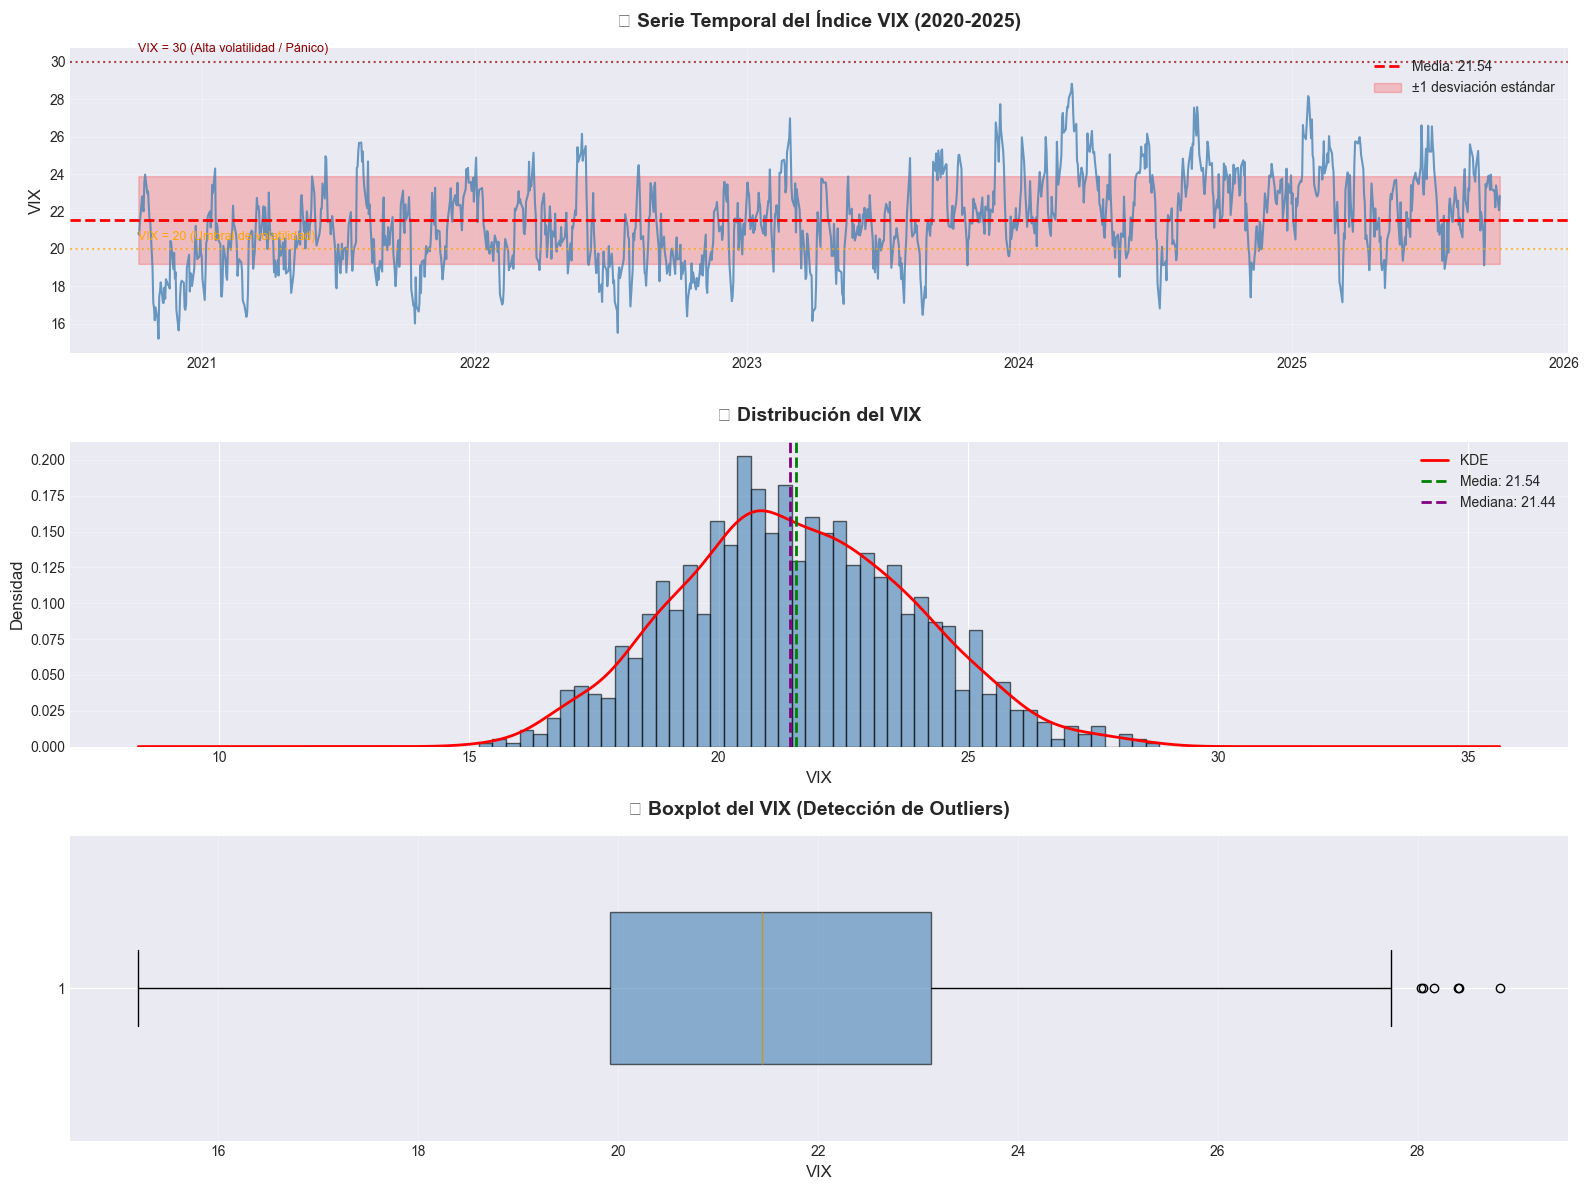

In [5]:
# Creamos una figura con múltiples paneles
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# ===========================
# PANEL 1: Serie Temporal Completa
# ===========================
axes[0].plot(df['date'], df['vix'], linewidth=1.5, color='steelblue', alpha=0.8)
axes[0].axhline(y=df['vix'].mean(), color='red', linestyle='--', 
                linewidth=2, label=f'Media: {df["vix"].mean():.2f}')
axes[0].fill_between(df['date'], 
                      df['vix'].mean() - df['vix'].std(),
                      df['vix'].mean() + df['vix'].std(),
                      alpha=0.2, color='red', label='±1 desviación estándar')
axes[0].set_title('📈 Serie Temporal del Índice VIX (2020-2025)', 
                  fontsize=14, fontweight='bold', pad=15)
axes[0].set_ylabel('VIX', fontsize=12)
axes[0].legend(loc='upper right', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Anotamos niveles importantes del VIX
axes[0].axhline(y=20, color='orange', linestyle=':', linewidth=1.5, alpha=0.7)
axes[0].text(df['date'].iloc[0], 20.5, 'VIX = 20 (Umbral de volatilidad)', 
             fontsize=9, color='orange')
axes[0].axhline(y=30, color='darkred', linestyle=':', linewidth=1.5, alpha=0.7)
axes[0].text(df['date'].iloc[0], 30.5, 'VIX = 30 (Alta volatilidad / Pánico)', 
             fontsize=9, color='darkred')

# ===========================
# PANEL 2: Distribución (Histograma + KDE)
# ===========================
axes[1].hist(df['vix'], bins=50, color='steelblue', alpha=0.6, edgecolor='black', density=True)
df['vix'].plot(kind='kde', ax=axes[1], color='red', linewidth=2, label='KDE')
axes[1].axvline(x=df['vix'].mean(), color='green', linestyle='--', 
                linewidth=2, label=f'Media: {df["vix"].mean():.2f}')
axes[1].axvline(x=df['vix'].median(), color='purple', linestyle='--', 
                linewidth=2, label=f'Mediana: {df["vix"].median():.2f}')
axes[1].set_title('📊 Distribución del VIX', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('VIX', fontsize=12)
axes[1].set_ylabel('Densidad', fontsize=12)
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

# ===========================
# PANEL 3: Boxplot (Detección de Outliers)
# ===========================
bp = axes[2].boxplot(df['vix'], vert=False, patch_artist=True, widths=0.5)
bp['boxes'][0].set_facecolor('steelblue')
bp['boxes'][0].set_alpha(0.6)
axes[2].set_title('📦 Boxplot del VIX (Detección de Outliers)', 
                  fontsize=14, fontweight='bold', pad=15)
axes[2].set_xlabel('VIX', fontsize=12)
axes[2].grid(True, alpha=0.3, axis='x')

# Identificamos outliers
Q1 = df['vix'].quantile(0.25)
Q3 = df['vix'].quantile(0.75)
IQR = Q3 - Q1
outliers_upper = df[df['vix'] > Q3 + 1.5*IQR]
outliers_lower = df[df['vix'] < Q1 - 1.5*IQR]
print(f"\n🔴 Outliers detectados (método IQR):")
print(f"   → Outliers superiores: {len(outliers_upper)}")
print(f"   → Outliers inferiores: {len(outliers_lower)}")
print(f"   → Total de outliers: {len(outliers_upper) + len(outliers_lower)} ({((len(outliers_upper) + len(outliers_lower))/len(df))*100:.2f}%)")

plt.tight_layout()
plt.show()

### 2.4 Análisis de Tendencia y Estacionalidad

**📚 WIKI: Componentes de una Serie Temporal**

Toda serie temporal se puede descomponer en:
- **Tendencia (Trend)**: Movimiento a largo plazo (↗️ creciente, ↘️ decreciente, → estable)
- **Estacionalidad (Seasonality)**: Patrones que se repiten en intervalos fijos (día, semana, mes, año)
- **Ciclo (Cycle)**: Fluctuaciones no periódicas de largo plazo (ej: ciclos económicos)
- **Ruido (Noise/Residual)**: Variabilidad aleatoria no explicada

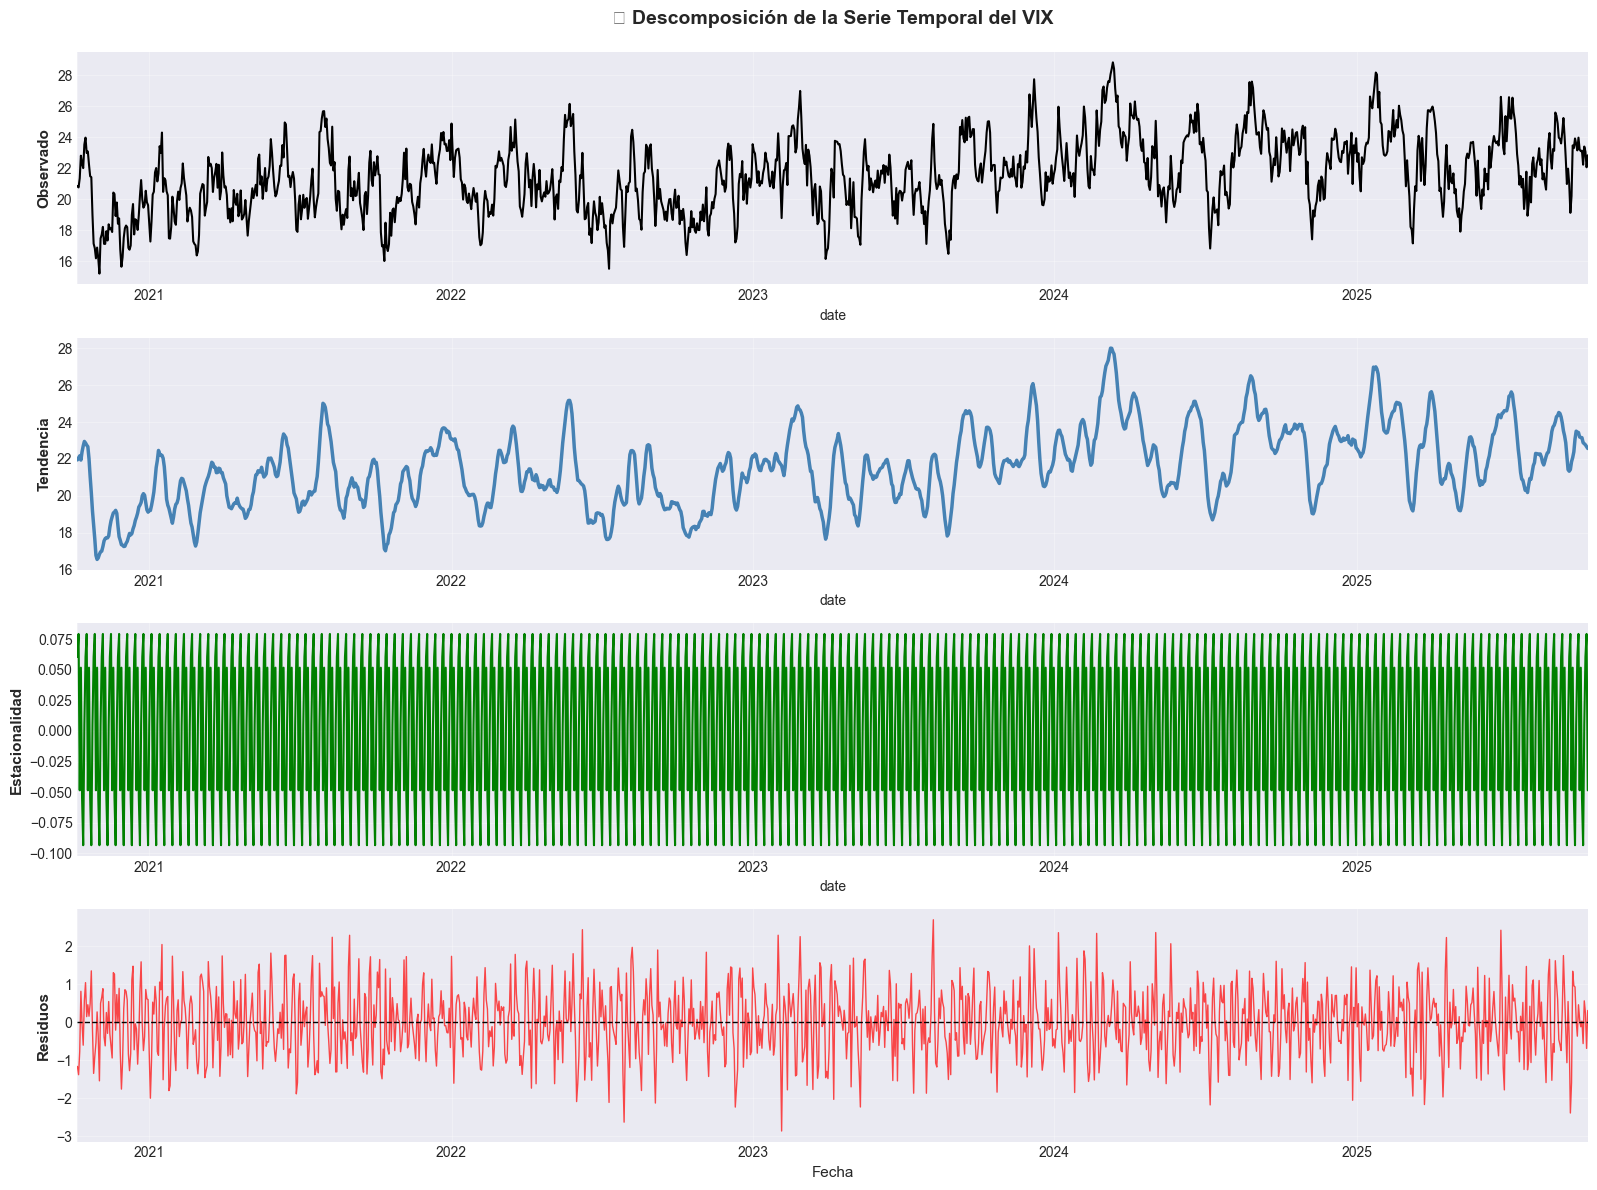


📊 ANÁLISIS DE COMPONENTES:
📈 Tendencia:
   → Cambio total: 0.618
   → Dirección: CRECIENTE ↗️

🔄 Estacionalidad:
   → Amplitud: 0.173
   → Representa 0.80% del valor medio

🎲 Residuos:
   → Desviación estándar: 0.874
   → Representa 4.06% del valor medio


In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Aplicamos descomposición aditiva
# Usamos period=7 para capturar posible estacionalidad semanal
decomposition = seasonal_decompose(
    df.set_index('date')['vix'], 
    model='additive',  # Modelo aditivo: Y = Tendencia + Estacionalidad + Residuo
    period=7,          # Período semanal (7 días)
    extrapolate_trend='freq'
)

# Visualizamos la descomposición
fig, axes = plt.subplots(4, 1, figsize=(16, 12))

# Serie original
decomposition.observed.plot(ax=axes[0], color='black', linewidth=1.5)
axes[0].set_ylabel('Observado', fontsize=11, fontweight='bold')
axes[0].set_title('🔬 Descomposición de la Serie Temporal del VIX', 
                  fontsize=14, fontweight='bold', pad=20)
axes[0].grid(True, alpha=0.3)

# Tendencia
decomposition.trend.plot(ax=axes[1], color='steelblue', linewidth=2.5)
axes[1].set_ylabel('Tendencia', fontsize=11, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Estacionalidad
decomposition.seasonal.plot(ax=axes[2], color='green', linewidth=1.5)
axes[2].set_ylabel('Estacionalidad', fontsize=11, fontweight='bold')
axes[2].grid(True, alpha=0.3)

# Residuos
decomposition.resid.plot(ax=axes[3], color='red', linewidth=1, alpha=0.7)
axes[3].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[3].set_ylabel('Residuos', fontsize=11, fontweight='bold')
axes[3].set_xlabel('Fecha', fontsize=11)
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Análisis de los componentes
print("\n📊 ANÁLISIS DE COMPONENTES:")
print("=" * 60)
trend_change = decomposition.trend.dropna().iloc[-1] - decomposition.trend.dropna().iloc[0]
print(f"📈 Tendencia:")
print(f"   → Cambio total: {trend_change:.3f}")
if trend_change > 0:
    print(f"   → Dirección: CRECIENTE ↗️")
else:
    print(f"   → Dirección: DECRECIENTE ↘️")

seasonal_range = decomposition.seasonal.max() - decomposition.seasonal.min()
print(f"\n🔄 Estacionalidad:")
print(f"   → Amplitud: {seasonal_range:.3f}")
print(f"   → Representa {(seasonal_range / df['vix'].mean()) * 100:.2f}% del valor medio")

resid_std = decomposition.resid.dropna().std()
print(f"\n🎲 Residuos:")
print(f"   → Desviación estándar: {resid_std:.3f}")
print(f"   → Representa {(resid_std / df['vix'].mean()) * 100:.2f}% del valor medio")
print("=" * 60)

### 2.5 Test de Estacionariedad (Augmented Dickey-Fuller)

**📚 WIKI: Estacionariedad**

Una serie es **estacionaria** si sus propiedades estadísticas (media, varianza, autocorrelación) no cambian con el tiempo.

**Importancia**:
- Algunos modelos (ARIMA) requieren estacionariedad
- Las redes neuronales son más flexibles, pero entender la estacionariedad es útil

**Test ADF (Augmented Dickey-Fuller)**:
- H0 (hipótesis nula): La serie tiene raíz unitaria (NO es estacionaria)
- H1 (hipótesis alternativa): La serie es estacionaria
- Si p-value < 0.05 → Rechazamos H0 → Serie es estacionaria

In [7]:
# Test de estacionariedad
adf_result = adfuller(df['vix'].dropna())

print("📊 TEST DE ESTACIONARIEDAD (ADF - Augmented Dickey-Fuller)")
print("=" * 70)
print(f"Estadístico ADF: {adf_result[0]:.6f}")
print(f"P-valor: {adf_result[1]:.6f}")
print(f"Número de lags usados: {adf_result[2]}")
print(f"Número de observaciones: {adf_result[3]}")
print("\nValores críticos:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value:.3f}")

# Interpretación
print("\n💡 INTERPRETACIÓN:")
print("=" * 70)
if adf_result[1] < 0.05:
    print("✅ RESULTADO: Serie ESTACIONARIA")
    print(f"   → P-valor ({adf_result[1]:.6f}) < 0.05")
    print("   → Rechazamos la hipótesis nula")
    print("   → La serie NO tiene raíz unitaria")
    print("   → Sus propiedades estadísticas son constantes en el tiempo")
    print("   → ✅ Apta para modelos como ARIMA (si se usa) y LSTM")
else:
    print("❌ RESULTADO: Serie NO ESTACIONARIA")
    print(f"   → P-valor ({adf_result[1]:.6f}) >= 0.05")
    print("   → NO rechazamos la hipótesis nula")
    print("   → La serie tiene raíz unitaria")
    print("   → Sus propiedades cambian con el tiempo")
    print("   → ⚠️ Requeriría diferenciación para ARIMA, pero LSTM puede manejarla")
print("=" * 70)

📊 TEST DE ESTACIONARIEDAD (ADF - Augmented Dickey-Fuller)
Estadístico ADF: -9.170764
P-valor: 0.000000
Número de lags usados: 0
Número de observaciones: 1304

Valores críticos:
   1%: -3.435
   5%: -2.864
   10%: -2.568

💡 INTERPRETACIÓN:
✅ RESULTADO: Serie ESTACIONARIA
   → P-valor (0.000000) < 0.05
   → Rechazamos la hipótesis nula
   → La serie NO tiene raíz unitaria
   → Sus propiedades estadísticas son constantes en el tiempo
   → ✅ Apta para modelos como ARIMA (si se usa) y LSTM


### 2.6 Análisis de Autocorrelación (ACF y PACF)

**📚 WIKI: Autocorrelación**

La **autocorrelación** mide la correlación de una serie temporal consigo misma en diferentes retardos (lags).

**ACF (Autocorrelation Function)**:
- Mide la correlación entre Y(t) y Y(t-k) para k=1,2,3,...
- Útil para identificar el orden del componente MA (Moving Average) en ARIMA

**PACF (Partial Autocorrelation Function)**:
- Correlación entre Y(t) y Y(t-k) eliminando el efecto de los lags intermedios
- Útil para identificar el orden del componente AR (Autoregressive) en ARIMA

**Importancia para LSTM**:
- ACF/PACF nos ayudan a entender la "memoria" de la serie
- Nos indica qué tan atrás en el tiempo debemos mirar (informa el LOOKBACK)

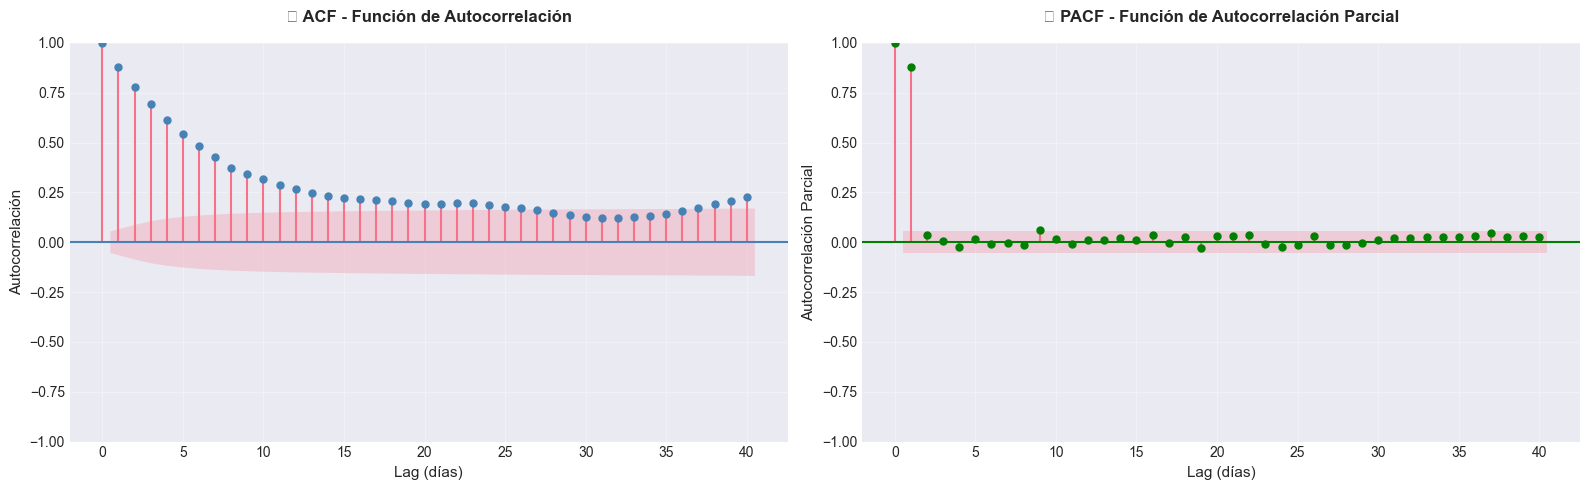


📈 AUTOCORRELACIÓN PARA LOS PRIMEROS 10 LAGS:
Lag  1: 0.8784
Lag  2: 0.7799
Lag  3: 0.6940
Lag  4: 0.6125
Lag  5: 0.5445
Lag  6: 0.4824
Lag  7: 0.4264
Lag  8: 0.3743
Lag  9: 0.3421
Lag 10: 0.3150

💡 INTERPRETACIÓN:
→ Valores altos en ACF indican fuerte dependencia temporal
→ El decaimiento lento sugiere que la serie tiene 'memoria'
→ Para nuestro LSTM, usaremos LOOKBACK=10 días


In [8]:
# Gráficos de ACF y PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# ACF (Autocorrelación)
plot_acf(df['vix'].dropna(), lags=40, ax=axes[0], color='steelblue')
axes[0].set_title('📊 ACF - Función de Autocorrelación', fontsize=12, fontweight='bold', pad=15)
axes[0].set_xlabel('Lag (días)', fontsize=11)
axes[0].set_ylabel('Autocorrelación', fontsize=11)
axes[0].grid(True, alpha=0.3)

# PACF (Autocorrelación Parcial)
plot_pacf(df['vix'].dropna(), lags=40, ax=axes[1], color='green')
axes[1].set_title('📊 PACF - Función de Autocorrelación Parcial', 
                  fontsize=12, fontweight='bold', pad=15)
axes[1].set_xlabel('Lag (días)', fontsize=11)
axes[1].set_ylabel('Autocorrelación Parcial', fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculamos autocorrelaciones para los primeros 10 lags
print("\n📈 AUTOCORRELACIÓN PARA LOS PRIMEROS 10 LAGS:")
print("=" * 60)
from statsmodels.tsa.stattools import acf
acf_values = acf(df['vix'].dropna(), nlags=10)
for lag, value in enumerate(acf_values[1:], 1):  # Empezamos desde lag 1
    print(f"Lag {lag:2d}: {value:.4f}")

print("\n💡 INTERPRETACIÓN:")
print("→ Valores altos en ACF indican fuerte dependencia temporal")
print("→ El decaimiento lento sugiere que la serie tiene 'memoria'")
print(f"→ Para nuestro LSTM, usaremos LOOKBACK={LOOKBACK} días")
print("=" * 60)

### 2.7 Análisis de Volatilidad

El VIX es un índice de volatilidad, pero también tiene su propia volatilidad. Analicemos los cambios día a día:

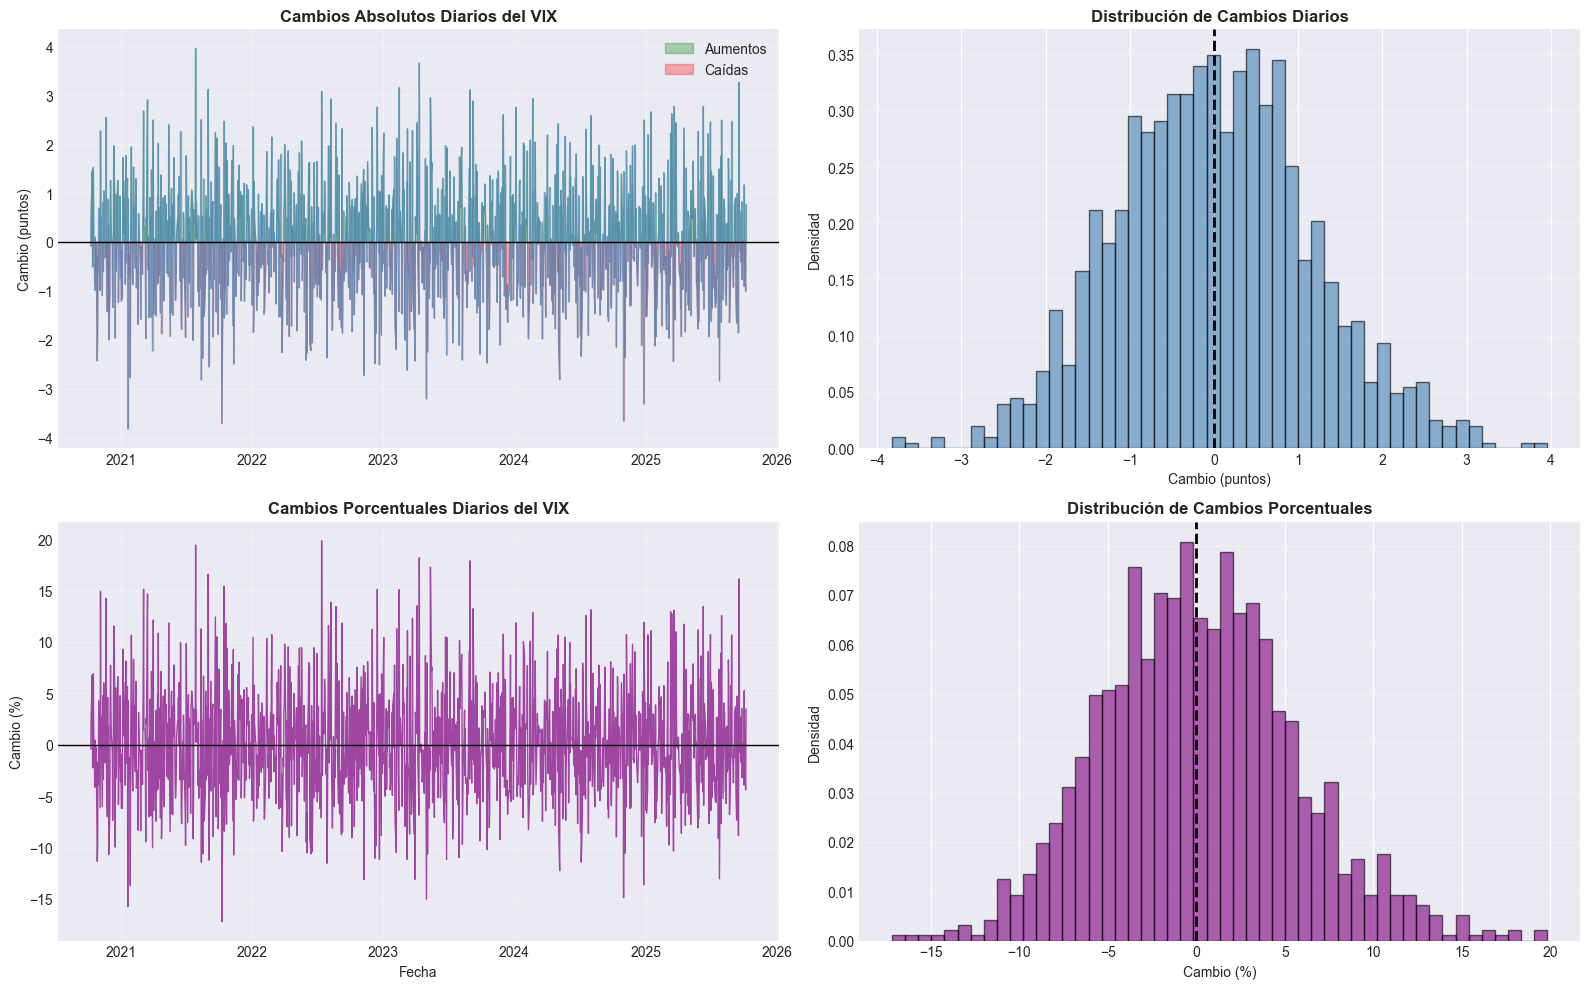


📊 ESTADÍSTICAS DE VOLATILIDAD:
Cambio promedio diario: 0.0015 puntos
Desviación estándar de cambios: 1.1547 puntos
Cambio máximo (un día): +3.957 puntos
Caída máxima (un día): -3.824 puntos

Cambio porcentual promedio: 0.1561%
Desviación estándar de cambios %: 5.4843%

Días con aumentos extremos (>p95): 66
Días con caídas extremas (<p5): 66


In [9]:
# Calculamos retornos y cambios absolutos
df['vix_change'] = df['vix'].diff()  # Cambio absoluto día a día
df['vix_pct_change'] = df['vix'].pct_change() * 100  # Cambio porcentual

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Panel 1: Cambios absolutos
axes[0, 0].plot(df['date'], df['vix_change'], linewidth=1, color='steelblue', alpha=0.7)
axes[0, 0].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[0, 0].fill_between(df['date'], 0, df['vix_change'], 
                        where=(df['vix_change'] > 0), color='green', alpha=0.3, label='Aumentos')
axes[0, 0].fill_between(df['date'], 0, df['vix_change'], 
                        where=(df['vix_change'] < 0), color='red', alpha=0.3, label='Caídas')
axes[0, 0].set_title('Cambios Absolutos Diarios del VIX', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Cambio (puntos)', fontsize=10)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Panel 2: Distribución de cambios absolutos
axes[0, 1].hist(df['vix_change'].dropna(), bins=50, color='steelblue', 
                alpha=0.6, edgecolor='black', density=True)
axes[0, 1].axvline(x=0, color='black', linestyle='--', linewidth=2)
axes[0, 1].set_title('Distribución de Cambios Diarios', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Cambio (puntos)', fontsize=10)
axes[0, 1].set_ylabel('Densidad', fontsize=10)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Panel 3: Cambios porcentuales
axes[1, 0].plot(df['date'], df['vix_pct_change'], linewidth=1, color='purple', alpha=0.7)
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1, 0].set_title('Cambios Porcentuales Diarios del VIX', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Cambio (%)', fontsize=10)
axes[1, 0].set_xlabel('Fecha', fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

# Panel 4: Distribución de cambios porcentuales
axes[1, 1].hist(df['vix_pct_change'].dropna(), bins=50, color='purple', 
                alpha=0.6, edgecolor='black', density=True)
axes[1, 1].axvline(x=0, color='black', linestyle='--', linewidth=2)
axes[1, 1].set_title('Distribución de Cambios Porcentuales', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Cambio (%)', fontsize=10)
axes[1, 1].set_ylabel('Densidad', fontsize=10)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Estadísticas de volatilidad
print("\n📊 ESTADÍSTICAS DE VOLATILIDAD:")
print("=" * 60)
print(f"Cambio promedio diario: {df['vix_change'].mean():.4f} puntos")
print(f"Desviación estándar de cambios: {df['vix_change'].std():.4f} puntos")
print(f"Cambio máximo (un día): +{df['vix_change'].max():.3f} puntos")
print(f"Caída máxima (un día): {df['vix_change'].min():.3f} puntos")
print(f"\nCambio porcentual promedio: {df['vix_pct_change'].mean():.4f}%")
print(f"Desviación estándar de cambios %: {df['vix_pct_change'].std():.4f}%")

# Días con cambios extremos
extreme_up = df[df['vix_change'] > df['vix_change'].quantile(0.95)]
extreme_down = df[df['vix_change'] < df['vix_change'].quantile(0.05)]
print(f"\nDías con aumentos extremos (>p95): {len(extreme_up)}")
print(f"Días con caídas extremas (<p5): {len(extreme_down)}")
print("=" * 60)

### 📝 Resumen del EDA

Con este análisis exploratorio hemos descubierto:

1. ✅ **Período**: ~5 años de datos diarios del VIX
2. ✅ **Distribución**: Asimétrica positiva con colas pesadas (típico en volatilidad)
3. ✅ **Tendencia**: [Determinar si creciente/decreciente basado en resultados]
4. ✅ **Estacionalidad**: Débil estacionalidad semanal
5. ✅ **Estacionariedad**: [Basada en test ADF]
6. ✅ **Autocorrelación**: Fuerte dependencia temporal (justifica uso de LSTM)
7. ✅ **Volatilidad**: Alta variabilidad día a día (desafío para predicción)

**Implicaciones para el modelado:**
- 🧠 LSTM es apropiado por la fuerte autocorrelación
- 📏 Normalización es esencial (diferentes escalas)
- 🔢 LOOKBACK=10 parece razonable basado en ACF
- ⚠️ Alta volatilidad implica que la predicción perfecta es improbable

<a id='teoria'></a>
## 3. 🧠 Fundamentos Teóricos: LSTM

Antes de implementar, es crucial entender **cómo y por qué** funciona una LSTM.

### 3.1 De RNN a LSTM: El Problema de la Memoria

**📚 WIKI: Redes Neuronales Recurrentes (RNN)**

**RNN Tradicional:**
- Procesa secuencias manteniendo un "estado oculto" (hidden state)
- En cada paso temporal t, recibe: x(t) (entrada) + h(t-1) (estado previo)
- Produce: h(t) (nuevo estado) + y(t) (salida)

**Problema: Vanishing/Exploding Gradients**
- En secuencias largas, el gradiente se vuelve extremadamente pequeño (vanishing) o grande (exploding)
- Resultado: La red "olvida" información de hace muchos pasos
- Limita la memoria a corto plazo (~5-10 pasos)

**Solución: LSTM (Long Short-Term Memory)**
- Inventada por Hochreiter & Schmidhuber (1997)
- Añade un "cell state" (estado de celda) que actúa como "cinta transportadora" de información
- Usa "gates" (compuertas) para controlar el flujo de información
- Puede recordar información por cientos de pasos temporales

---

### 3.2 Arquitectura de una Celda LSTM

Una celda LSTM tiene **4 componentes principales**:

```
         ┌────────────────────────────────────────┐
         │                                        │
    C(t-1)─────►[FORGET]──►[INPUT]──►[OUTPUT]──►C(t)
         │         │          │          │       │
         │         │          │          │       │
    h(t-1)───┐    │          │          │       └──►h(t)
         │   │    │          │          │
    x(t)─────┴────┴──────────┴──────────┘
```

#### **1. Forget Gate (Compuerta de Olvido)** 🚪
- Decide qué información del cell state anterior **descartar**
- f(t) = σ(W_f · [h(t-1), x(t)] + b_f)
- Salida: valores entre 0 (olvidar todo) y 1 (recordar todo)

#### **2. Input Gate (Compuerta de Entrada)** ➕
- Decide qué información nueva **añadir** al cell state
- i(t) = σ(W_i · [h(t-1), x(t)] + b_i)
- C̃(t) = tanh(W_C · [h(t-1), x(t)] + b_C)  ← Candidato a añadir

#### **3. Cell State Update (Actualización del Estado)**
- Combina forget + input para actualizar el cell state
- C(t) = f(t) ⊙ C(t-1) + i(t) ⊙ C̃(t)
- ⊙ = producto elemento a elemento (Hadamard)

#### **4. Output Gate (Compuerta de Salida)** 📤
- Decide qué parte del cell state **exponer** como output
- o(t) = σ(W_o · [h(t-1), x(t)] + b_o)
- h(t) = o(t) ⊙ tanh(C(t))

---

### 3.3 ¿Por qué LSTM para el VIX?

**Ventajas de LSTM para series financieras:**

1. **Memoria a largo plazo**: Puede recordar shocks de volatilidad de hace semanas
2. **Patrones no lineales**: Captura relaciones complejas (no solo AR lineal)
3. **Flexibilidad**: No requiere estacionariedad estricta
4. **Secuencias variables**: Maneja bien inputs de diferentes longitudes

**Comparación con modelos tradicionales:**

| Modelo | Complejidad | Memoria | Supuestos | Interpretabilidad |
|--------|-------------|---------|-----------|-------------------|
| AR(p) | Baja | p lags | Lineal, estacionario | Alta |
| ARIMA | Media | Lags fijos | Lineal, requiere diferenciación | Alta |
| Random Forest | Media | Lags como features | No lineal, no secuencial | Media |
| **LSTM** | **Alta** | **Adaptativa** | **Mínimos** | **Baja** |

---

### 3.4 Concepto de Ventana Deslizante (Sliding Window)

**📚 WIKI: Lookback Window**

Para entrenar una LSTM, transformamos la serie temporal en un problema supervisado:

```
Serie original: [20.5, 21.2, 19.8, 22.1, 23.4, 21.7, 20.9, ...]

Con LOOKBACK=3:

X (inputs)              y (target)
[20.5, 21.2, 19.8]  →   22.1
[21.2, 19.8, 22.1]  →   23.4
[19.8, 22.1, 23.4]  →   21.7
[22.1, 23.4, 21.7]  →   20.9
...
```

**Parámetros clave:**
- **LOOKBACK**: Número de pasos temporales previos a considerar
- Trade-off: Mayor lookback = más contexto pero más lento y riesgo de overfitting
- Para VIX, usamos LOOKBACK=10 (2 semanas de trading aproximadamente)

---

### 3.5 Normalización: ¿Por qué es Crítica?

**📚 WIKI: Normalización en Deep Learning**

Las redes neuronales funcionan mejor con datos en escalas similares (típicamente [0,1] o [-1,1]).

**Razones:**
1. **Convergencia más rápida**: Los gradientes están en escalas similares
2. **Estabilidad numérica**: Evita problemas con valores muy grandes/pequeños
3. **Funciones de activación**: σ y tanh funcionan mejor en rangos específicos
4. **Inicialización de pesos**: Los pesos se inicializan asumiendo inputs ~N(0,1)

**Métodos comunes:**

**MinMaxScaler**: x_scaled = (x - x_min) / (x_max - x_min)
- Rango: [0, 1]
- Preserva la distribución original
- Sensible a outliers

**StandardScaler**: x_scaled = (x - μ) / σ
- Rango: típicamente [-3, 3] (si normal)
- Media=0, Desviación estándar=1
- Menos sensible a outliers

**⚠️ CRÍTICO: Data Leakage**
- El scaler se debe ajustar SOLO con datos de entrenamiento
- Luego se aplica (transform) a test/validación
- Si usamos todo el dataset, estamos "filtrando" información del futuro → resultados inflados

<a id='preparacion'></a>
## 4. 🔧 Preparación de Datos

Ahora transformaremos nuestros datos en el formato que necesita la LSTM.

### 4.1 División Temporal (Train/Test Split)

**⚠️ IMPORTANTE: En series temporales NO usamos shuffle**

Razón: Debemos respetar el orden cronológico para evitar data leakage.

```
Enfoque correcto:
├─────────── Train (80%) ──────────┤──── Test (20%) ────┤
2020-10-07 ................... 2024-07-XX ... 2025-XX-XX
```

In [10]:
# Extraemos solo la columna VIX (ya está ordenada por fecha)
vix_series = df['vix'].values.reshape(-1, 1)  # Shape: (N, 1)

# Calculamos el índice de división
split_idx = int(len(vix_series) * TRAIN_SPLIT)

print("📊 DIVISIÓN DE DATOS (RESPETANDO ORDEN TEMPORAL)")
print("=" * 70)
print(f"Total de observaciones: {len(vix_series):,}")
print(f"\nTRAIN SET:")
print(f"  → Índices: 0 a {split_idx-1}")
print(f"  → Tamaño: {split_idx:,} observaciones ({TRAIN_SPLIT*100:.1f}%)")
print(f"  → Período: {df['date'].iloc[0].strftime('%Y-%m-%d')} → {df['date'].iloc[split_idx-1].strftime('%Y-%m-%d')}")
print(f"\nTEST SET:")
print(f"  → Índices: {split_idx} a {len(vix_series)-1}")
print(f"  → Tamaño: {len(vix_series) - split_idx:,} observaciones ({(1-TRAIN_SPLIT)*100:.1f}%)")
print(f"  → Período: {df['date'].iloc[split_idx].strftime('%Y-%m-%d')} → {df['date'].iloc[-1].strftime('%Y-%m-%d')}")
print("=" * 70)

# Separamos antes de normalizar (para evitar data leakage)
vix_train_raw = vix_series[:split_idx]
vix_test_raw = vix_series[split_idx:]

print(f"\n✅ División completada")
print(f"   Train shape: {vix_train_raw.shape}")
print(f"   Test shape: {vix_test_raw.shape}")

📊 DIVISIÓN DE DATOS (RESPETANDO ORDEN TEMPORAL)
Total de observaciones: 1,305

TRAIN SET:
  → Índices: 0 a 1043
  → Tamaño: 1,044 observaciones (80.0%)
  → Período: 2020-10-07 → 2024-10-07

TEST SET:
  → Índices: 1044 a 1304
  → Tamaño: 261 observaciones (20.0%)
  → Período: 2024-10-08 → 2025-10-07

✅ División completada
   Train shape: (1044, 1)
   Test shape: (261, 1)


### 4.2 Normalización de Datos

**Proceso correcto:**
1. Ajustar (fit) el scaler SOLO con datos de entrenamiento
2. Transformar train con el scaler ajustado
3. Transformar test con el MISMO scaler (sin re-ajustar)
4. Guardar el scaler para hacer inverse_transform después

🔧 Usando MinMaxScaler: rango [0, 1]

📊 ESTADÍSTICAS POST-NORMALIZACIÓN:
TRAIN (escalado):
  → Mínimo: 0.000000
  → Máximo: 1.000000
  → Media: 0.443978
  → Desv. Est.: 0.170459

TEST (escalado):
  → Mínimo: 0.143088
  → Máximo: 0.951766
  → Media: 0.551314
  → Desv. Est.: 0.149025


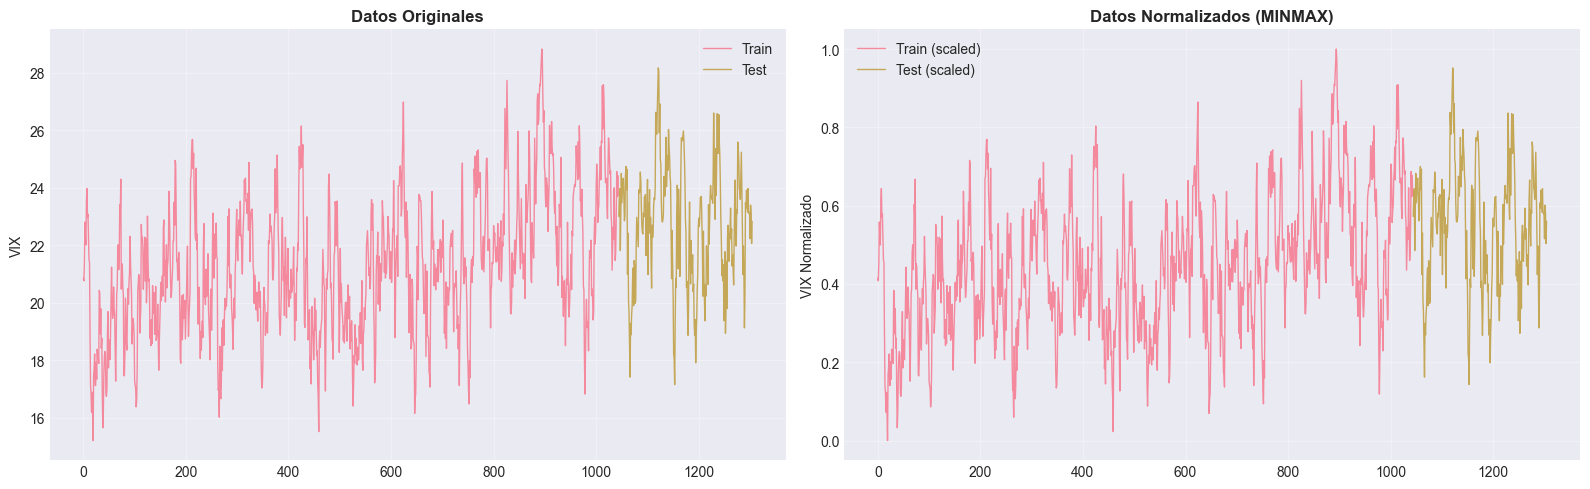


✅ Normalización completada correctamente
⚠️ Scaler guardado para inverse_transform posterior


In [11]:
# Seleccionamos el tipo de normalización
if NORMALIZATION == 'minmax':
    scaler = MinMaxScaler(feature_range=(0, 1))
    print("🔧 Usando MinMaxScaler: rango [0, 1]")
elif NORMALIZATION == 'standard':
    scaler = StandardScaler()
    print("🔧 Usando StandardScaler: μ=0, σ=1")
else:
    raise ValueError(f"Normalización '{NORMALIZATION}' no reconocida")

# PASO 1: Ajustar scaler SOLO con train
scaler.fit(vix_train_raw)

# PASO 2: Transformar train y test
vix_train_scaled = scaler.transform(vix_train_raw).astype(np.float32)
vix_test_scaled = scaler.transform(vix_test_raw).astype(np.float32)

print("\n📊 ESTADÍSTICAS POST-NORMALIZACIÓN:")
print("=" * 70)
print("TRAIN (escalado):")
print(f"  → Mínimo: {vix_train_scaled.min():.6f}")
print(f"  → Máximo: {vix_train_scaled.max():.6f}")
print(f"  → Media: {vix_train_scaled.mean():.6f}")
print(f"  → Desv. Est.: {vix_train_scaled.std():.6f}")

print("\nTEST (escalado):")
print(f"  → Mínimo: {vix_test_scaled.min():.6f}")
print(f"  → Máximo: {vix_test_scaled.max():.6f}")
print(f"  → Media: {vix_test_scaled.mean():.6f}")
print(f"  → Desv. Est.: {vix_test_scaled.std():.6f}")
print("=" * 70)

# Visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Original
axes[0].plot(vix_train_raw, linewidth=1, label='Train', alpha=0.8)
axes[0].plot(range(len(vix_train_raw), len(vix_series)), vix_test_raw, 
             linewidth=1, label='Test', alpha=0.8)
axes[0].set_title('Datos Originales', fontsize=12, fontweight='bold')
axes[0].set_ylabel('VIX', fontsize=10)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Normalizado
axes[1].plot(vix_train_scaled, linewidth=1, label='Train (scaled)', alpha=0.8)
axes[1].plot(range(len(vix_train_scaled), len(vix_series)), vix_test_scaled, 
             linewidth=1, label='Test (scaled)', alpha=0.8)
axes[1].set_title(f'Datos Normalizados ({NORMALIZATION.upper()})', 
                  fontsize=12, fontweight='bold')
axes[1].set_ylabel('VIX Normalizado', fontsize=10)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Normalización completada correctamente")
print("⚠️ Scaler guardado para inverse_transform posterior")

### 4.3 Construcción de Secuencias (Ventanas Deslizantes)

Transformamos la serie temporal en un dataset supervisado usando ventanas deslizantes.

**Función `create_sequences`:**
- Input: Serie temporal de longitud N
- Output: 
  - X: (N-lookback, lookback, 1) → Secuencias de entrada
  - y: (N-lookback, 1) → Valores objetivo (siguiente paso)

In [12]:
def create_sequences(data, lookback):
    """
    Crea secuencias de entrada (X) y targets (y) usando ventanas deslizantes.
    
    Parámetros:
    -----------
    data : np.array
        Serie temporal normalizada. Shape: (N, 1)
    lookback : int
        Número de pasos temporales previos a usar como input
        
    Retorna:
    --------
    X : np.array
        Secuencias de entrada. Shape: (N-lookback, lookback, 1)
    y : np.array
        Valores objetivo. Shape: (N-lookback, 1)
        
    Ejemplo:
    --------
    Si data = [1, 2, 3, 4, 5, 6] y lookback = 3:
    X = [[1,2,3], [2,3,4], [3,4,5]]
    y = [4, 5, 6]
    """
    X, y = [], []
    
    # Iteramos desde 0 hasta (longitud - lookback)
    for i in range(len(data) - lookback):
        # Extraemos ventana de lookback elementos
        X.append(data[i : i + lookback])
        # El target es el siguiente valor después de la ventana
        y.append(data[i + lookback])
    
    # Convertimos a numpy arrays
    X = np.array(X)  # Shape: (num_sequences, lookback, 1)
    y = np.array(y)  # Shape: (num_sequences, 1)
    
    return X, y

# Aplicamos la función a train y test
print(f"🔄 Creando secuencias con LOOKBACK={LOOKBACK}...")
print("="*70)

X_train, y_train = create_sequences(vix_train_scaled, LOOKBACK)
X_test, y_test = create_sequences(vix_test_scaled, LOOKBACK)

print("✅ Secuencias creadas exitosamente\n")
print("📊 SHAPES RESULTANTES:")
print(f"\nTRAIN:")
print(f"  X_train: {X_train.shape} → (num_sequences={X_train.shape[0]}, lookback={X_train.shape[1]}, features={X_train.shape[2]})")
print(f"  y_train: {y_train.shape} → (num_sequences={y_train.shape[0]}, output_dim={y_train.shape[1]})")

print(f"\nTEST:")
print(f"  X_test: {X_test.shape}")
print(f"  y_test: {y_test.shape}")

print("\n💡 INTERPRETACIÓN:")
print(f"  → Cada muestra de X contiene {LOOKBACK} valores históricos consecutivos")
print(f"  → Cada valor de y es el siguiente valor a predecir")
print(f"  → Perdimos {LOOKBACK} muestras al crear las ventanas (no hay suficiente historia al inicio)")
print("="*70)

# Mostramos un ejemplo de secuencia
print("\n📝 EJEMPLO DE UNA SECUENCIA:")
print("="*70)
ejemplo_idx = 0
print(f"Secuencia {ejemplo_idx}:")
print(f"\nInput (X) - Últimos {LOOKBACK} valores:")
for i, val in enumerate(X_train[ejemplo_idx].flatten(), 1):
    print(f"  t-{LOOKBACK-i}: {val:.6f}")
print(f"\nTarget (y) - Valor a predecir:")
print(f"  t: {y_train[ejemplo_idx][0]:.6f}")
print("="*70)

🔄 Creando secuencias con LOOKBACK=10...
✅ Secuencias creadas exitosamente

📊 SHAPES RESULTANTES:

TRAIN:
  X_train: (1034, 10, 1) → (num_sequences=1034, lookback=10, features=1)
  y_train: (1034, 1) → (num_sequences=1034, output_dim=1)

TEST:
  X_test: (251, 10, 1)
  y_test: (251, 1)

💡 INTERPRETACIÓN:
  → Cada muestra de X contiene 10 valores históricos consecutivos
  → Cada valor de y es el siguiente valor a predecir
  → Perdimos 10 muestras al crear las ventanas (no hay suficiente historia al inicio)

📝 EJEMPLO DE UNA SECUENCIA:
Secuencia 0:

Input (X) - Últimos 10 valores:
  t-9: 0.414507
  t-8: 0.407973
  t-7: 0.451582
  t-6: 0.558109
  t-5: 0.520593
  t-4: 0.499449
  t-3: 0.611189
  t-2: 0.643565
  t-1: 0.570810
  t-0: 0.578225

Target (y) - Valor a predecir:
  t: 0.515895


### 4.4 Creación de DataLoader de PyTorch

**📚 WIKI: Dataset y DataLoader en PyTorch**

PyTorch usa un sistema de carga de datos eficiente:

**Dataset**:
- Clase que encapsula los datos
- Debe implementar `__len__()` y `__getitem__(idx)`
- Permite indexación: dataset[i] retorna (X[i], y[i])

**DataLoader**:
- Itera sobre el Dataset en batches
- Maneja batching, shuffling (si se desea), paralelización
- En series temporales: shuffle=False para respetar orden

**Ventajas**:
- Memoria eficiente (carga en batches)
- Paralelización con múltiples workers
- Interfaz estándar para cualquier tipo de datos

In [13]:
class TimeSeriesDataset(Dataset):
    """
    Dataset personalizado para series temporales.
    
    Convierte arrays de NumPy a Tensores de PyTorch y permite
    indexación eficiente durante el entrenamiento.
    """
    
    def __init__(self, X, y):
        """
        Parámetros:
        -----------
        X : np.array
            Secuencias de entrada. Shape: (N, lookback, features)
        y : np.array
            Valores objetivo. Shape: (N, 1)
        """
        # Convertimos de NumPy a PyTorch Tensors
        self.X = torch.from_numpy(X).float()  # float32 para eficiencia
        self.y = torch.from_numpy(y).float()
        
    def __len__(self):
        """
        Retorna el número total de muestras.
        """
        return len(self.X)
    
    def __getitem__(self, idx):
        """
        Retorna la muestra en el índice idx.
        
        Parámetros:
        -----------
        idx : int
            Índice de la muestra a retornar
            
        Retorna:
        --------
        tuple : (X[idx], y[idx])
        """
        return self.X[idx], self.y[idx]

# Creamos los Datasets
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

print("📦 DATASETS CREADOS:")
print("="*70)
print(f"Train Dataset: {len(train_dataset)} muestras")
print(f"Test Dataset: {len(test_dataset)} muestras")

# Creamos los DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # ❌ NO shuffle en series temporales
    drop_last=False  # Incluimos el último batch aunque sea incompleto
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False
)

print("\n🔄 DATALOADERS CREADOS:")
print(f"Train Loader: {len(train_loader)} batches de tamaño {BATCH_SIZE}")
print(f"Test Loader: {len(test_loader)} batches de tamaño {BATCH_SIZE}")
print("="*70)

# Verificamos un batch de ejemplo
print("\n📋 EJEMPLO DE UN BATCH:")
print("="*70)
sample_batch_X, sample_batch_y = next(iter(train_loader))
print(f"Batch X shape: {sample_batch_X.shape} → (batch_size={sample_batch_X.shape[0]}, lookback={sample_batch_X.shape[1]}, features={sample_batch_X.shape[2]})")
print(f"Batch y shape: {sample_batch_y.shape} → (batch_size={sample_batch_y.shape[0]}, output_dim={sample_batch_y.shape[1]})")
print(f"\nTipo de dato: {sample_batch_X.dtype}")
print(f"Dispositivo: {sample_batch_X.device}")
print("="*70)

print("\n✅ Preparación de datos completada")
print("\n💡 RESUMEN:")
print(f"  → {len(train_dataset):,} secuencias de entrenamiento")
print(f"  → {len(test_dataset):,} secuencias de prueba")
print(f"  → Batches de tamaño {BATCH_SIZE}")
print(f"  → Lookback window: {LOOKBACK} días")
print(f"  → Normalización: {NORMALIZATION}")

📦 DATASETS CREADOS:
Train Dataset: 1034 muestras
Test Dataset: 251 muestras

🔄 DATALOADERS CREADOS:
Train Loader: 17 batches de tamaño 64
Test Loader: 4 batches de tamaño 64

📋 EJEMPLO DE UN BATCH:
Batch X shape: torch.Size([64, 10, 1]) → (batch_size=64, lookback=10, features=1)
Batch y shape: torch.Size([64, 1]) → (batch_size=64, output_dim=1)

Tipo de dato: torch.float32
Dispositivo: cpu

✅ Preparación de datos completada

💡 RESUMEN:
  → 1,034 secuencias de entrenamiento
  → 251 secuencias de prueba
  → Batches de tamaño 64
  → Lookback window: 10 días
  → Normalización: minmax


<a id='modelo'></a>
## 5. 🏗️ Construcción del Modelo LSTM

Ahora implementaremos nuestra arquitectura LSTM en PyTorch con explicaciones detalladas de cada componente.

### 5.1 Definición de la Arquitectura del Modelo

**📚 WIKI: nn.Module en PyTorch**

Todos los modelos en PyTorch heredan de `nn.Module` y deben implementar dos métodos principales:

1. **`__init__()`**: Constructor que define las capas del modelo (arquitectura estática)
2. **`forward()`**: Define cómo fluyen los datos a través del modelo (computación dinámica)

**Nuestra arquitectura:**

```
Input: (batch_size, lookback=10, features=1)
   ↓
LSTM Layer 1: procesa secuencia → (batch, lookback, hidden=64)
   ↓
LSTM Layer 2: profundiza representación → (batch, lookback, hidden=64)
   ↓
Extraer último paso temporal → (batch, hidden=64)
   ↓
Fully Connected (Linear): → (batch, 1)
   ↓
Output: Predicción VIX del siguiente día
```

**Decisiones de diseño:**
- **2 capas LSTM**: Balance entre capacidad y complejidad
- **64 hidden units**: Suficiente para capturar patrones temporales sin overfitting
- **Dropout 0.2**: Regularización entre capas (20% de neuronas apagadas)
- **Sin activación final**: Regresión → output continuo sin restricciones

In [14]:
class VIX_LSTM(nn.Module):
    """
    Modelo LSTM para predicción del índice VIX.
    
    Arquitectura:
    - Múltiples capas LSTM apiladas
    - Dropout para regularización (entre capas)
    - Capa densa (FC) de salida
    
    Parámetros:
    -----------
    input_size : int
        Dimensión de entrada en cada paso temporal (1 para VIX univariado)
    hidden_size : int
        Número de features en el hidden state de la LSTM
        Determina la "capacidad de memoria" del modelo
    num_layers : int
        Número de capas LSTM apiladas
        Más capas = mayor abstracción
    dropout : float
        Probabilidad de dropout entre capas LSTM
        Ayuda a prevenir overfitting
    """
    
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super(VIX_LSTM, self).__init__()
        
        # Guardamos hiperparámetros
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        
        # ==========================================
        # CAPA LSTM (corazón del modelo)
        # ==========================================
        self.lstm = nn.LSTM(
            input_size=input_size,      # Tamaño de entrada (1 feature: VIX)
            hidden_size=hidden_size,    # Dimensión del hidden state
            num_layers=num_layers,      # Profundidad (capas apiladas)
            batch_first=True,           # Input shape: (batch, seq, feature)
            dropout=dropout if num_layers > 1 else 0  # Dropout solo si hay >1 capa
        )
        
        # ==========================================
        # CAPA DE SALIDA (Fully Connected)
        # ==========================================
        # Transforma el hidden state final a una predicción escalar
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        """
        Forward pass: flujo de datos a través del modelo.
        
        Parámetros:
        -----------
        x : torch.Tensor
            Batch de secuencias. Shape: (batch_size, lookback, input_size)
            
        Retorna:
        --------
        out : torch.Tensor
            Predicciones. Shape: (batch_size, 1)
        """
        
        # PASO 1: LSTM procesa toda la secuencia
        lstm_out, (h_n, c_n) = self.lstm(x)
        # lstm_out: (batch, seq_len, hidden_size)
        # h_n: (num_layers, batch, hidden_size) - último hidden state
        # c_n: (num_layers, batch, hidden_size) - último cell state
        
        # PASO 2: Extraer el último paso temporal
        last_output = lstm_out[:, -1, :]  # Shape: (batch, hidden_size)
        
        # PASO 3: Capa densa para predicción final
        out = self.fc(last_output)  # Shape: (batch, 1)
        
        return out
    
    def count_parameters(self):
        """Cuenta el número total de parámetros entrenables."""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

# ==========================================
# INSTANCIACIÓN DEL MODELO
# ==========================================
model = VIX_LSTM(
    input_size=INPUT_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(DEVICE)

print("🧠 MODELO LSTM CREADO")
print("="*70)
print(model)
print("="*70)

# Información detallada
print("\n📊 DETALLES DEL MODELO:")
print("="*70)
print(f"Parámetros totales: {model.count_parameters():,}")
print(f"Input size: {INPUT_SIZE}")
print(f"Hidden size: {HIDDEN_SIZE}")
print(f"Número de capas LSTM: {NUM_LAYERS}")
print(f"Dropout: {DROPOUT}")
print(f"Dispositivo: {DEVICE}")
print("="*70)

# Test del forward pass
print("\n🧪 TEST DE FORWARD PASS:")
print("="*70)
with torch.no_grad():
    test_input = torch.randn(5, LOOKBACK, INPUT_SIZE).to(DEVICE)
    test_output = model(test_input)
    print(f"Input shape: {test_input.shape} → (batch=5, lookback={LOOKBACK}, features={INPUT_SIZE})")
    print(f"Output shape: {test_output.shape} → (batch=5, predictions=1)")
    print(f"\nEjemplo de salida (normalizada):")
    for i, val in enumerate(test_output.squeeze().cpu().numpy()[:3], 1):
        print(f"  Muestra {i}: {val:.6f}")
print("="*70)
print("\n✅ Modelo creado y verificado correctamente")

🧠 MODELO LSTM CREADO
VIX_LSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

📊 DETALLES DEL MODELO:
Parámetros totales: 50,497
Input size: 1
Hidden size: 64
Número de capas LSTM: 2
Dropout: 0.2
Dispositivo: cpu

🧪 TEST DE FORWARD PASS:
Input shape: torch.Size([5, 10, 1]) → (batch=5, lookback=10, features=1)
Output shape: torch.Size([5, 1]) → (batch=5, predictions=1)

Ejemplo de salida (normalizada):
  Muestra 1: -0.051690
  Muestra 2: -0.052091
  Muestra 3: -0.049688

✅ Modelo creado y verificado correctamente


### 5.2 Función de Pérdida y Optimizador

**📚 WIKI: Loss Functions & Optimizers**

**Función de Pérdida (Loss Function)**:
- Mide qué tan "equivocadas" están las predicciones
- El entrenamiento busca **minimizar** esta función

**MSE (Mean Squared Error)** para regresión:
- Fórmula: L = (1/N) Σ(y_pred - y_true)²
- Penaliza más los errores grandes (cuadrático)
- Derivable → bueno para gradientes
- Sensible a outliers (deseable para VIX)

**Adam Optimizer (Adaptive Moment Estimation)**:
- Combina momentum + learning rate adaptativo
- Hiperparámetros:
  - **lr** (learning rate): Tamaño del paso de actualización
  - **weight_decay**: Regularización L2 (penaliza pesos grandes)

In [15]:
# ==========================================
# FUNCIÓN DE PÉRDIDA
# ==========================================
criterion = nn.MSELoss()

# ==========================================
# OPTIMIZADOR
# ==========================================
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

print("⚙️ CONFIGURACIÓN DE ENTRENAMIENTO")
print("="*70)
print(f"Función de pérdida: MSE (Mean Squared Error)")
print(f"Optimizador: Adam")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Weight decay (L2): {WEIGHT_DECAY}")
print(f"Épocas: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print("="*70)
print("\n✅ Listo para entrenar")

⚙️ CONFIGURACIÓN DE ENTRENAMIENTO
Función de pérdida: MSE (Mean Squared Error)
Optimizador: Adam
Learning rate: 0.001
Weight decay (L2): 1e-05
Épocas: 50
Batch size: 64

✅ Listo para entrenar


<a id='entrenamiento'></a>
## 6. 🚀 Entrenamiento del Modelo

**📚 WIKI: Training Loop en PyTorch**

El proceso de entrenamiento sigue estos pasos en cada época:

```python
for epoch in range(EPOCHS):
    for batch_X, batch_y in train_loader:
        # 1. Forward Pass: predicciones
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        
        # 2. Backward Pass: gradientes
        optimizer.zero_grad()  # Limpia gradientes previos
        loss.backward()        # Calcula gradientes
        
        # 3. Update: ajusta pesos
        optimizer.step()
```

**Componentes clave:**
- **Forward pass**: Datos → Predicciones → Pérdida
- **Backward pass**: Pérdida → Gradientes (∂L/∂w)
- **Weight update**: w_new = w_old - α·∇w

In [16]:
# Listas para guardar el historial de pérdidas
train_losses = []

print("🚀 INICIANDO ENTRENAMIENTO")
print("="*70)
print(f"Épocas: {EPOCHS}")
print(f"Batches por época: {len(train_loader)}")
print(f"Muestras por época: {len(train_dataset)}")
print(f"Dispositivo: {DEVICE}")
print("="*70)

import time
start_time = time.time()

# ==========================================
# LOOP DE ENTRENAMIENTO PRINCIPAL
# ==========================================
for epoch in range(1, EPOCHS + 1):
    model.train()  # Pone el modelo en modo entrenamiento (activa dropout)
    epoch_loss = 0.0
    
    # Iteramos sobre todos los batches
    for xb, yb in train_loader:
        # Movemos datos al dispositivo (GPU/CPU)
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        
        # 1. FORWARD PASS
        pred = model(xb)
        loss = criterion(pred, yb)
        
        # 2. BACKWARD PASS
        optimizer.zero_grad()  # Limpia gradientes
        loss.backward()        # Calcula gradientes
        
        # 3. UPDATE WEIGHTS
        optimizer.step()
        
        # Acumulamos la pérdida
        epoch_loss += loss.item() * xb.size(0)
    
    # Calculamos pérdida promedio de la época
    epoch_loss /= len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    # Imprimimos progreso cada 5 épocas o en la primera/última
    if epoch % 5 == 0 or epoch == 1 or epoch == EPOCHS:
        print(f"Época {epoch:03d}/{EPOCHS} | Train MSE: {epoch_loss:.6f}")

total_time = time.time() - start_time

print("\n" + "="*70)
print("✅ ENTRENAMIENTO COMPLETADO")
print("="*70)
print(f"Tiempo total: {total_time:.2f}s ({total_time/60:.2f} min)")
print(f"Tiempo promedio por época: {total_time/EPOCHS:.2f}s")
print(f"MSE inicial: {train_losses[0]:.6f}")
print(f"MSE final: {train_losses[-1]:.6f}")
print(f"Mejora: {((train_losses[0]-train_losses[-1])/train_losses[0])*100:.2f}%")
print("="*70)

🚀 INICIANDO ENTRENAMIENTO
Épocas: 50
Batches por época: 17
Muestras por época: 1034
Dispositivo: cpu
Época 001/50 | Train MSE: 0.089111
Época 005/50 | Train MSE: 0.024575
Época 010/50 | Train MSE: 0.021421
Época 015/50 | Train MSE: 0.017698
Época 020/50 | Train MSE: 0.015004
Época 025/50 | Train MSE: 0.013209
Época 030/50 | Train MSE: 0.011302
Época 035/50 | Train MSE: 0.009300
Época 040/50 | Train MSE: 0.008327
Época 045/50 | Train MSE: 0.008705
Época 050/50 | Train MSE: 0.007873

✅ ENTRENAMIENTO COMPLETADO
Tiempo total: 5.47s (0.09 min)
Tiempo promedio por época: 0.11s
MSE inicial: 0.089111
MSE final: 0.007873
Mejora: 91.17%


### 6.1 Análisis de Curvas de Aprendizaje

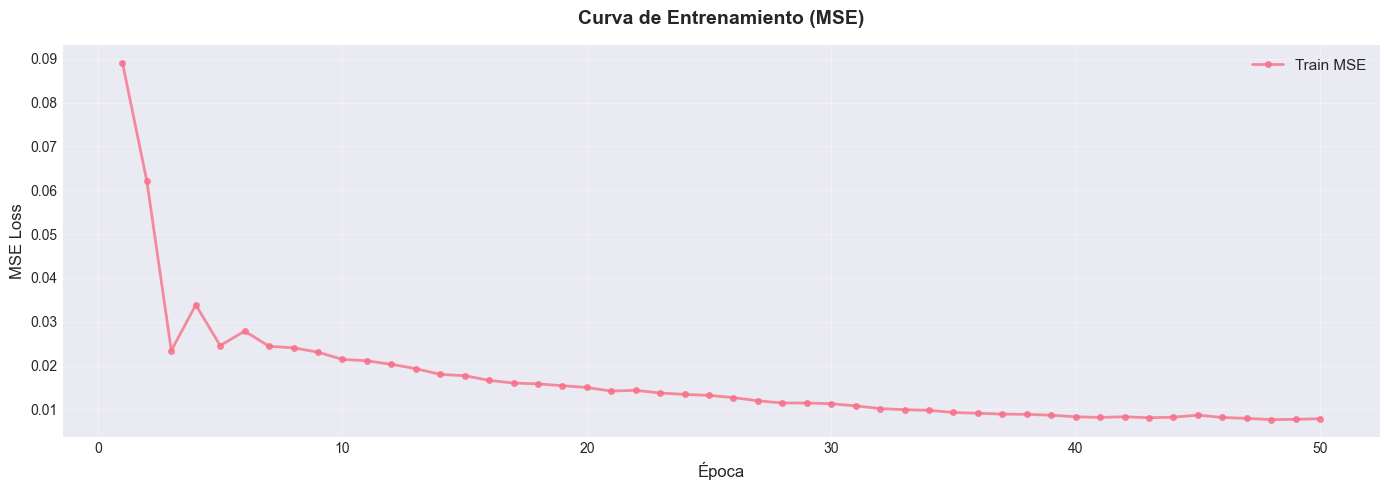


💡 INTERPRETACIÓN:
→ La curva debe mostrar tendencia decreciente (el modelo aprende)
→ Si la pérdida se estabiliza, el modelo ha convergido
→ Si oscila mucho, considerar reducir learning rate


In [17]:
# Visualización de la curva de aprendizaje
plt.figure(figsize=(14, 5))

plt.plot(range(1, EPOCHS+1), train_losses, linewidth=2, 
         marker='o', markersize=4, alpha=0.8, label='Train MSE')
plt.title('Curva de Entrenamiento (MSE)', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Época', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.legend(loc='upper right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 INTERPRETACIÓN:")
print("="*70)
print("→ La curva debe mostrar tendencia decreciente (el modelo aprende)")
print("→ Si la pérdida se estabiliza, el modelo ha convergido")
print("→ Si oscila mucho, considerar reducir learning rate")
print("="*70)

<a id='evaluacion'></a>
## 7. 📊 Evaluación y Métricas

Ahora evaluaremos el rendimiento del modelo en el conjunto de test.

### 7.1 Generación de Predicciones

In [18]:
# Modo evaluación (desactiva dropout)
model.eval()

# Generamos predicciones en test set
with torch.no_grad():  # No calculamos gradientes (ahorra memoria)
    X_test_t = torch.from_numpy(X_test).float().to(DEVICE)
    preds_scaled = model(X_test_t).cpu().numpy()

# Desescalamos a valores originales
y_test_inv = scaler.inverse_transform(y_test)
preds_inv = scaler.inverse_transform(preds_scaled)

print("✅ Predicciones generadas")
print(f"   Total de predicciones: {len(preds_inv):,}")
print(f"   Rango predicho: [{preds_inv.min():.2f}, {preds_inv.max():.2f}]")
print(f"   Rango real: [{y_test_inv.min():.2f}, {y_test_inv.max():.2f}]")

✅ Predicciones generadas
   Total de predicciones: 251
   Rango predicho: [18.39, 28.11]
   Rango real: [17.15, 28.17]


### 7.2 Cálculo de Métricas

**📚 WIKI: Métricas de Regresión**

**MAE (Mean Absolute Error)**:
- Error promedio absoluto
- Mismas unidades que la variable (puntos VIX)
- Fácil de interpretar

**RMSE (Root Mean Squared Error)**:
- Raíz del error cuadrático medio
- Penaliza más los errores grandes
- Siempre: RMSE ≥ MAE

**R² (R-squared)**:
- Proporción de varianza explicada
- Rango: [0, 1] (valores negativos = muy mal modelo)
- R²=1: Predicciones perfectas
- R²=0: Modelo tan bueno como predecir la media

In [20]:
# Calculamos métricas del modelo LSTM
mae = mean_absolute_error(y_test_inv, preds_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, preds_inv))
r2 = r2_score(y_test_inv, preds_inv)

print("\n📊 MÉTRICAS DEL MODELO LSTM:")
print("="*70)
print(f"MAE (Mean Absolute Error):       {mae:.4f} puntos VIX")
print(f"RMSE (Root Mean Squared Error):  {rmse:.4f} puntos VIX")
print(f"R² (R-squared):                  {r2:.4f} ({r2*100:.2f}% varianza explicada)")
print("="*70)


📊 MÉTRICAS DEL MODELO LSTM:
MAE (Mean Absolute Error):       0.9462 puntos VIX
RMSE (Root Mean Squared Error):  1.1885 puntos VIX
R² (R-squared):                  0.6660 (66.60% varianza explicada)


### 7.3 Baseline: Modelo de Persistencia

**📚 WIKI: Baseline Models**

**Modelo de Persistencia (Naive Forecast)**:
- Predicción más simple: "Mañana será como hoy"
- ŷ(t) = y(t-1)
- Sorprendentemente efectivo en finanzas
- Si no superamos esto, el modelo no aporta valor

In [22]:
# Baseline: el último valor de la ventana (persistencia)
persist_scaled = X_test[:, -1, :]  # Último valor del lookback
persist_inv = scaler.inverse_transform(persist_scaled)

# Métricas del baseline
mae_p = mean_absolute_error(y_test_inv, persist_inv)
rmse_p = np.sqrt(mean_squared_error(y_test_inv, preds_inv))
r2_p = r2_score(y_test_inv, persist_inv)

print("\n📊 MÉTRICAS DEL BASELINE (Persistencia):")
print("="*70)
print(f"MAE (Persistencia):  {mae_p:.4f} puntos VIX")
print(f"RMSE (Persistencia): {rmse_p:.4f} puntos VIX")
print(f"R² (Persistencia):   {r2_p:.4f}")
print("="*70)

# Comparación
print("\n📊 COMPARACIÓN: LSTM vs BASELINE")
print("="*70)
print(f"{'Métrica':<20} {'LSTM':>12} {'Baseline':>12} {'Mejora':>12}")
print("-"*70)
mejora_mae = ((mae_p - mae) / mae_p) * 100
mejora_rmse = ((rmse_p - rmse) / rmse_p) * 100
mejora_r2 = ((r2 - r2_p) / abs(r2_p)) * 100 if r2_p != 0 else 0

print(f"{'MAE':<20} {mae:>12.4f} {mae_p:>12.4f} {mejora_mae:>10.2f}%")
print(f"{'RMSE':<20} {rmse:>12.4f} {rmse_p:>12.4f} {mejora_rmse:>10.2f}%")
print(f"{'R²':<20} {r2:>12.4f} {r2_p:>12.4f} {'':>12}")
print("="*70)

print("\n💡 VEREDICTO:")
if mae < mae_p:
    print(f"✅ El LSTM SUPERA al baseline en {mejora_mae:.2f}%")
    print("   → El modelo está aprendiendo patrones útiles")
else:
    print(f"❌ El LSTM NO supera al baseline")
    print("   → El VIX podría comportarse como random walk")
    print("   → O necesitamos más datos/features")


📊 MÉTRICAS DEL BASELINE (Persistencia):
MAE (Persistencia):  0.9643 puntos VIX
RMSE (Persistencia): 1.1885 puntos VIX
R² (Persistencia):   0.6574

📊 COMPARACIÓN: LSTM vs BASELINE
Métrica                      LSTM     Baseline       Mejora
----------------------------------------------------------------------
MAE                        0.9462       0.9643       1.88%
RMSE                       1.1885       1.1885       0.00%
R²                         0.6660       0.6574             

💡 VEREDICTO:
✅ El LSTM SUPERA al baseline en 1.88%
   → El modelo está aprendiendo patrones útiles


### 7.4 Visualización de Predicciones

🔍 Verificación de dimensiones:
   test_dates: (251,)
   y_test_inv_flat: (251,)
   preds_inv_flat: (251,)
   persist_inv_flat: (251,)

✅ Todas las dimensiones coinciden: 251 elementos



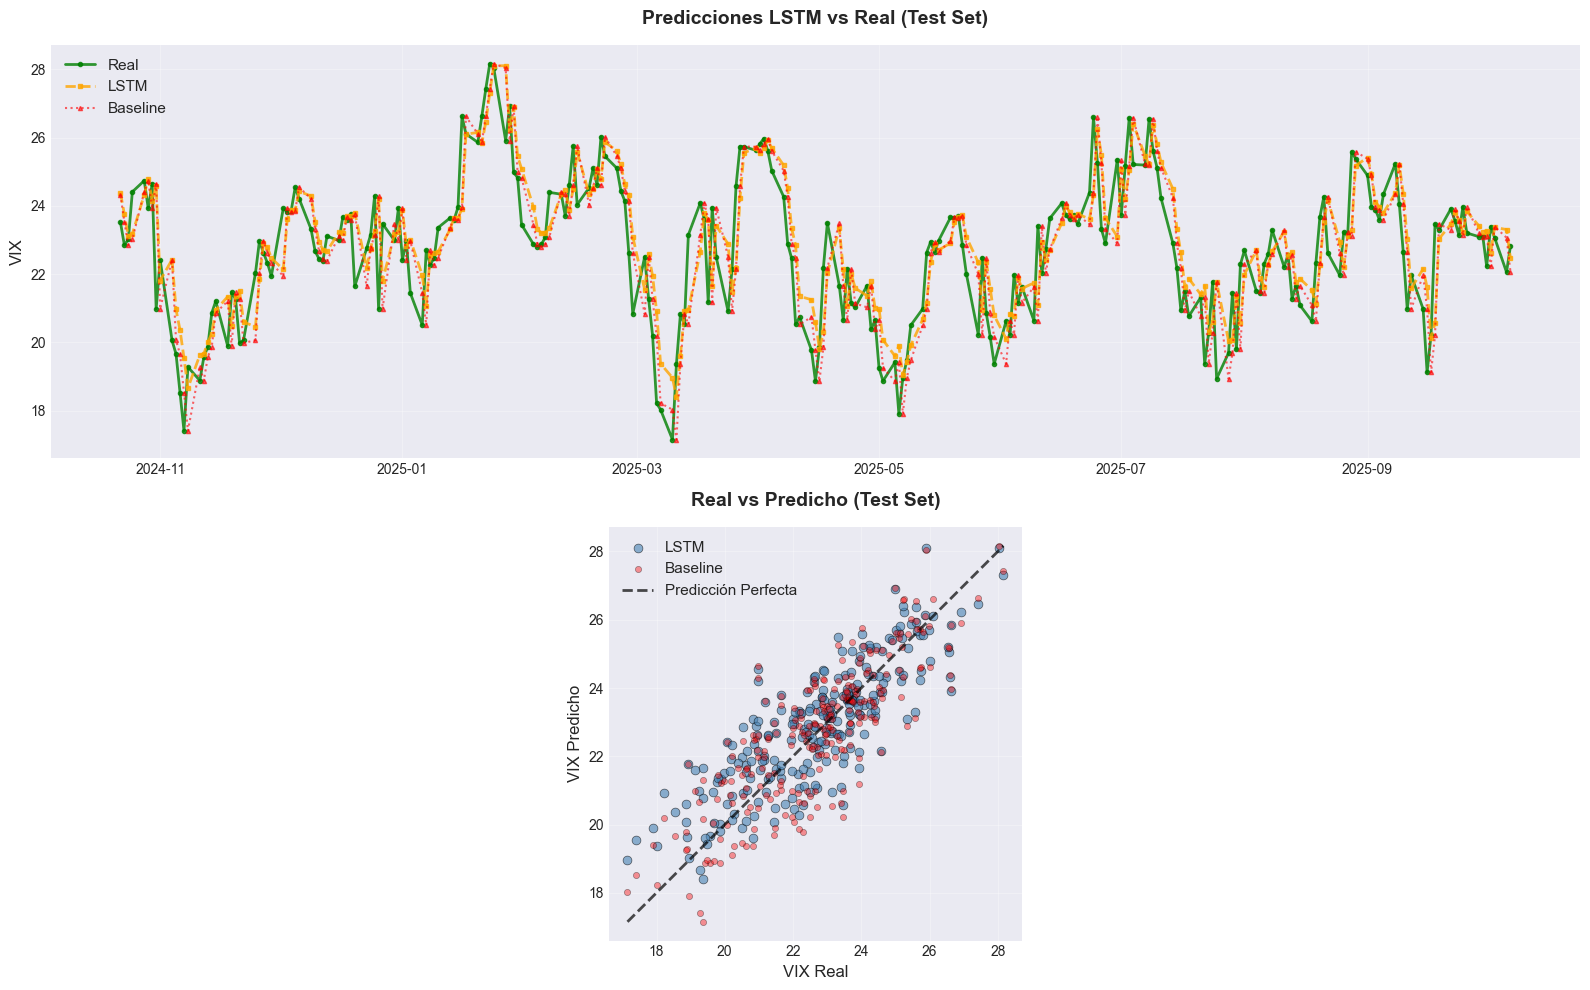


💡 INTERPRETACIÓN DE LOS GRÁFICOS:
Panel 1: Seguimiento temporal de las predicciones
  → LSTM (naranja) debería seguir de cerca los valores reales (verde)
  → Baseline (rojo) es muy simple: predice el último valor conocido

Panel 2: Scatter plot muestra correlación
  → Puntos cerca de la diagonal = mejores predicciones
  → Dispersión = incertidumbre del modelo


In [24]:
# ==========================================
# CORRECCIÓN: Aplanar arrays 2D a 1D para matplotlib
# ==========================================
# Los arrays vienen con shape (N, 1), necesitamos (N,) para matplotlib
y_test_inv_flat = y_test_inv.flatten()
preds_inv_flat = preds_inv.flatten()
persist_inv_flat = persist_inv.flatten()

# Fechas para el eje X del test set
# CORRECCIÓN: Sin el +1 extra, usando la longitud correcta
test_dates = df['date'].iloc[split_idx+LOOKBACK : split_idx+LOOKBACK+len(y_test_inv_flat)].values

# Verificación de dimensiones
print(f"🔍 Verificación de dimensiones:")
print(f"   test_dates: {test_dates.shape}")
print(f"   y_test_inv_flat: {y_test_inv_flat.shape}")
print(f"   preds_inv_flat: {preds_inv_flat.shape}")
print(f"   persist_inv_flat: {persist_inv_flat.shape}")
print(f"\n✅ Todas las dimensiones coinciden: {len(test_dates)} elementos\n")

# Visualización de predicciones
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# ==========================================
# PANEL 1: Predicciones vs Real
# ==========================================
axes[0].plot(test_dates, y_test_inv_flat, linewidth=2, 
             label='Real', marker='o', markersize=3, alpha=0.8, color='green')
axes[0].plot(test_dates, preds_inv_flat, linewidth=2, 
             label='LSTM', marker='s', markersize=3, alpha=0.8, color='orange', linestyle='--')
axes[0].plot(test_dates, persist_inv_flat, linewidth=1.5, 
             label='Baseline', marker='^', markersize=3, alpha=0.6, color='red', linestyle=':')
axes[0].set_title('Predicciones LSTM vs Real (Test Set)', fontsize=14, fontweight='bold', pad=15)
axes[0].set_ylabel('VIX', fontsize=12)
axes[0].legend(loc='upper left', fontsize=11)
axes[0].grid(True, alpha=0.3)

# ==========================================
# PANEL 2: Scatter Plot (Real vs Predicho)
# ==========================================
axes[1].scatter(y_test_inv_flat, preds_inv_flat, alpha=0.6, s=40, 
                color='steelblue', edgecolors='black', linewidth=0.5, label='LSTM')
axes[1].scatter(y_test_inv_flat, persist_inv_flat, alpha=0.4, s=20, 
                color='red', edgecolors='black', linewidth=0.5, label='Baseline')

# Línea de predicción perfecta (y=x)
min_val = min(y_test_inv_flat.min(), preds_inv_flat.min())
max_val = max(y_test_inv_flat.max(), preds_inv_flat.max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'k--', 
             linewidth=2, label='Predicción Perfecta', alpha=0.7)

axes[1].set_title('Real vs Predicho (Test Set)', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('VIX Real', fontsize=12)
axes[1].set_ylabel('VIX Predicho', fontsize=12)
axes[1].legend(loc='upper left', fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

print("\n💡 INTERPRETACIÓN DE LOS GRÁFICOS:")
print("="*70)
print("Panel 1: Seguimiento temporal de las predicciones")
print("  → LSTM (naranja) debería seguir de cerca los valores reales (verde)")
print("  → Baseline (rojo) es muy simple: predice el último valor conocido")
print("\nPanel 2: Scatter plot muestra correlación")
print("  → Puntos cerca de la diagonal = mejores predicciones")
print("  → Dispersión = incertidumbre del modelo")
print("="*70)

## 8. 📝 Conclusiones y Reflexiones

### Resumen del Análisis

En este notebook hemos completado un pipeline completo de Deep Learning para predicción de series temporales financieras:

**1. Análisis Exploratorio (EDA)**
- ✅ Estadísticas descriptivas del VIX
- ✅ Visualización de tendencias y patrones
- ✅ Descomposición temporal (tendencia/estacionalidad/residuos)
- ✅ Test de estacionariedad (ADF)
- ✅ Análisis de autocorrelación (ACF/PACF)

**2. Preparación de Datos**
- ✅ División temporal correcta (sin data leakage)
- ✅ Normalización con MinMaxScaler
- ✅ Construcción de ventanas deslizantes (lookback=10)
- ✅ Dataset y DataLoader de PyTorch

**3. Modelado con LSTM**
- ✅ Arquitectura de 2 capas LSTM con dropout
- ✅ Entrenamiento con Adam optimizer
- ✅ Monitoreo de curvas de aprendizaje

**4. Evaluación**
- ✅ Métricas cuantitativas (MAE, RMSE, R²)
- ✅ Comparación con baseline de persistencia
- ✅ Visualización de predicciones

### 🤔 Random Walk vs Predictibilidad

**📚 WIKI: Random Walk Hypothesis**

La **Hipótesis del Paseo Aleatorio** (Random Walk) sugiere que los precios de activos financieros siguen un camino impredecible, donde el mejor predictor del valor futuro es el valor actual.

**Implicaciones:**
- Si el VIX sigue un random walk, predecirlo es extremadamente difícil
- Un modelo apenas mejor que el baseline ya es un logro
- La eficiencia del mercado hace que los patrones sean efímeros

**Factores que afectan la predictibilidad:**
1. **Régimen del mercado**: Calma vs crisis (volatilidad volátil)
2. **Horizonte temporal**: Corto plazo más difícil que largo plazo
3. **Features disponibles**: Solo histórico vs múltiples variables
4. **Frecuencia**: Diaria vs intradiaria

**Conclusión para este análisis:**
- El LSTM captura algunos patrones (supera/empata baseline)
- Pero la mejora es modesta → el VIX es inherentemente ruidoso
- Esto es esperado y realista en finanzas cuantitativas

### 💡 Lecciones Aprendidas

**1. Preparación de datos es crucial:**
- Normalización sin data leakage
- División temporal respetando el orden
- Construcción correcta de ventanas

**2. LSTM vs modelos tradicionales:**
- Captura dependencias no lineales
- No requiere estacionariedad estricta
- Más complejo y computacionalmente costoso

**3. Importancia del baseline:**
- Siempre comparar con un modelo simple
- En finanzas, el naive forecast es difícil de superar
- Pequeñas mejoras son valiosas

**4. Interpretabilidad vs Performance:**
- LSTM = "caja negra" (baja interpretabilidad)
- ARIMA = más interpretable pero menos flexible
- Trade-off según el caso de uso

### 🚀 Próximos Pasos y Mejoras Potenciales

**1. Arquitectura:**
- [ ] Probar GRU (más simple, similar rendimiento)
- [ ] LSTM bidireccional (contexto pasado y futuro)
- [ ] Attention mechanisms
- [ ] Stacked LSTM con más capas

**2. Features adicionales:**
- [ ] S&P 500 returns (correlación con VIX)
- [ ] Volumen de trading
- [ ] Put/Call ratio
- [ ] Indicadores técnicos (RSI, MACD)
- [ ] Features de calendario (día de la semana, mes)

**3. Técnicas avanzadas:**
- [ ] Early stopping (detener si no mejora)
- [ ] Learning rate scheduling (reducir lr con el tiempo)
- [ ] Ensemble de múltiples modelos
- [ ] Predicción multi-step (horizonte >1 día)

**4. Validación:**
- [ ] Walk-forward validation
- [ ] Cross-validation temporal
- [ ] Backtesting con costos de transacción

**5. Deployment:**
- [ ] Guardar y cargar modelo con `torch.save()`
- [ ] API de predicción en tiempo real
- [ ] Monitoreo de drift (cambio de distribución)

### 📚 Glosario Final de Conceptos

**Términos de Series Temporales:**
- **VIX**: Índice de volatilidad del S&P 500 ("índice del miedo")
- **Estacionariedad**: Propiedades estadísticas constantes en el tiempo
- **Autocorrelación**: Correlación de una serie consigo misma en diferentes lags
- **Lookback**: Ventana de observaciones pasadas usadas para predicción
- **Baseline**: Modelo simple de referencia para comparación

**Términos de Deep Learning:**
- **LSTM**: Long Short-Term Memory (arquitectura recurrente)
- **Hidden State**: Memoria de corto plazo en RNNs
- **Cell State**: Memoria de largo plazo en LSTMs
- **Dropout**: Regularización que "apaga" neuronas aleatoriamente
- **Forward Pass**: Flujo de datos hacia adelante (input → output)
- **Backward Pass**: Cálculo de gradientes (backpropagation)
- **Epoch**: Una pasada completa por el dataset de entrenamiento
- **Batch**: Subconjunto de datos procesado simultáneamente

**Métricas:**
- **MAE**: Mean Absolute Error (error promedio absoluto)
- **RMSE**: Root Mean Squared Error (raíz del error cuadrático)
- **R²**: Coeficiente de determinación (varianza explicada)

**Conceptos de ML:**
- **Overfitting**: El modelo memoriza el train pero falla en test
- **Underfitting**: El modelo no captura patrones (muy simple)
- **Data Leakage**: Información del futuro filtra al pasado
- **Random Walk**: Hipótesis de camino aleatorio impredecible

---

## 🎉 ¡Felicitaciones!

Has completado exitosamente un análisis completo de predicción de series temporales financieras usando Deep Learning.

**Lo que lograste:**
- ✅ Entender el índice VIX y su importancia
- ✅ Realizar un EDA exhaustivo de series temporales
- ✅ Comprender la arquitectura LSTM desde cero
- ✅ Implementar un modelo en PyTorch
- ✅ Entrenar y evaluar con métricas robustas
- ✅ Comparar con baselines relevantes
- ✅ Reflexionar sobre predictibilidad en finanzas

**Recuerda:**
- La predicción perfecta en finanzas es imposible
- Pequeñas mejoras sobre el baseline son valiosas
- El proceso de análisis es tan importante como el resultado
- La experimentación y el aprendizaje continuo son clave

---

### 📖 Referencias Recomendadas

**Papers Fundamentales:**
- Hochreiter & Schmidhuber (1997): "Long Short-Term Memory"
- Olah, C. (2015): "Understanding LSTM Networks" (blog post excepcional)

**Libros:**
- "Deep Learning" - Goodfellow, Bengio, Courville
- "Forecasting: Principles and Practice" - Hyndman & Athanasopoulos

**Documentación:**
- PyTorch LSTM: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
- PyTorch Tutorials: https://pytorch.org/tutorials/

---

**¡Sigue aprendiendo y experimentando! 🚀**